# Import Libraries

In [273]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import cufflinks as cf   # !pip install cufflinks

from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.metrics import log_loss, recall_score, accuracy_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_auc_score, auc
from sklearn.metrics import roc_curve, average_precision_score, precision_recall_curve
from sklearn.metrics import make_scorer

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler


import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
%matplotlib inline
#%matplotlib notebook
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [169]:
df = pd.read_csv("new_data.csv")

In [170]:
df.shape

(442, 16)

In [171]:
# Separate the last 30 rows
control = df[-30:]

# Update the original DataFrame by excluding the last 30 rows
df = df[:-30]

# Save the dropped part to a new CSV file
control.to_csv('control.csv', index=False)

In [172]:
df1 = df.copy()

In [173]:
df.shape

(412, 16)

In [174]:
df.head(5)

ASIN  price  quantity            open_date item_is_marketplace  \
0  B091K1WBH3 36.890        11  2021-09-15 11:06:55                   y   
1  B003SLFA76 25.830         0  2021-09-18 21:21:43                   y   
2  B00RBPLLS2 26.950        18  2021-09-18 21:28:10                   y   
3  B00RBPLLQE 21.490         0  2021-09-18 21:37:26                   y   
4  B07CXDB7NK 25.850         0  2021-09-18 21:39:26                   y   

   featured_offer_buy_box_percentage  Sales Rank: Current  Reviews: Rating  \
0                             84.750            40271.000            4.700   
1                             51.820            47872.000            4.400   
2                             89.620             9085.000            4.600   
3                              0.000            61977.000            4.400   
4                             29.410             4714.000            4.700   

   Reviews: Review Count  Buy Box 🚚: Stock Buy Box: Is FBA    Brand  \
0                467.000            10.000              no  Softlan   
1                 34.000            61.000              no     HELA   
2                512.000             6.000              no     HELA   
3                250.000             0.000              no     HELA   
4                581.000             0.000              no     HELA   

  Prime Eligible (Buy Box) Subscribe and Save Last Price Change  \
0                       no                 no  2024/01/08 23:42   
1                       no                 no  2024/06/03 05:48   
2                       no                 no  2024/05/25 05:28   
3                       no                 no  2024/06/03 16:46   
4                       no                 no  2024/04/22 04:24   

   Buy Box Seller  
0               1  
1               1  
2               1  
3               0  
4               0

In [175]:
df["Buy Box Seller"].value_counts()

Buy Box Seller
1    280
0    132
Name: count, dtype: int64

In [176]:
df["Buy Box Seller"].nunique()

2

In [177]:
df.shape

(412, 16)

In [178]:
df["Buy Box: Is FBA"].value_counts()

Buy Box: Is FBA
no     306
yes    106
Name: count, dtype: int64

In [179]:
df.columns

Index(['ASIN', 'price', 'quantity', 'open_date', 'item_is_marketplace',
       'featured_offer_buy_box_percentage', 'Sales Rank: Current',
       'Reviews: Rating', 'Reviews: Review Count', 'Buy Box 🚚: Stock',
       'Buy Box: Is FBA', 'Brand', 'Prime Eligible (Buy Box)',
       'Subscribe and Save', 'Last Price Change', 'Buy Box Seller'],
      dtype='object')

# Possible Feature Selection Version

1.They have used seven features which are **price difference to lowest, price ratio to lowest, average rating, positive feedback, feedback count, is product FBA, and is Amazon seller.**

2.The data consist of **price, product rating, feedback count, FBA condition, stock availability, and Amazon’s choice condition features of products, seller information, and time of crawling.**
Additional to these features, they have created more than 20 candidate features such as **weekday, the ratio of previous price and current price, the difference between the lowest price and current price, and ratio and difference of current price and 4, 8, 16, 32 rolling mean of prices, etc.**

3.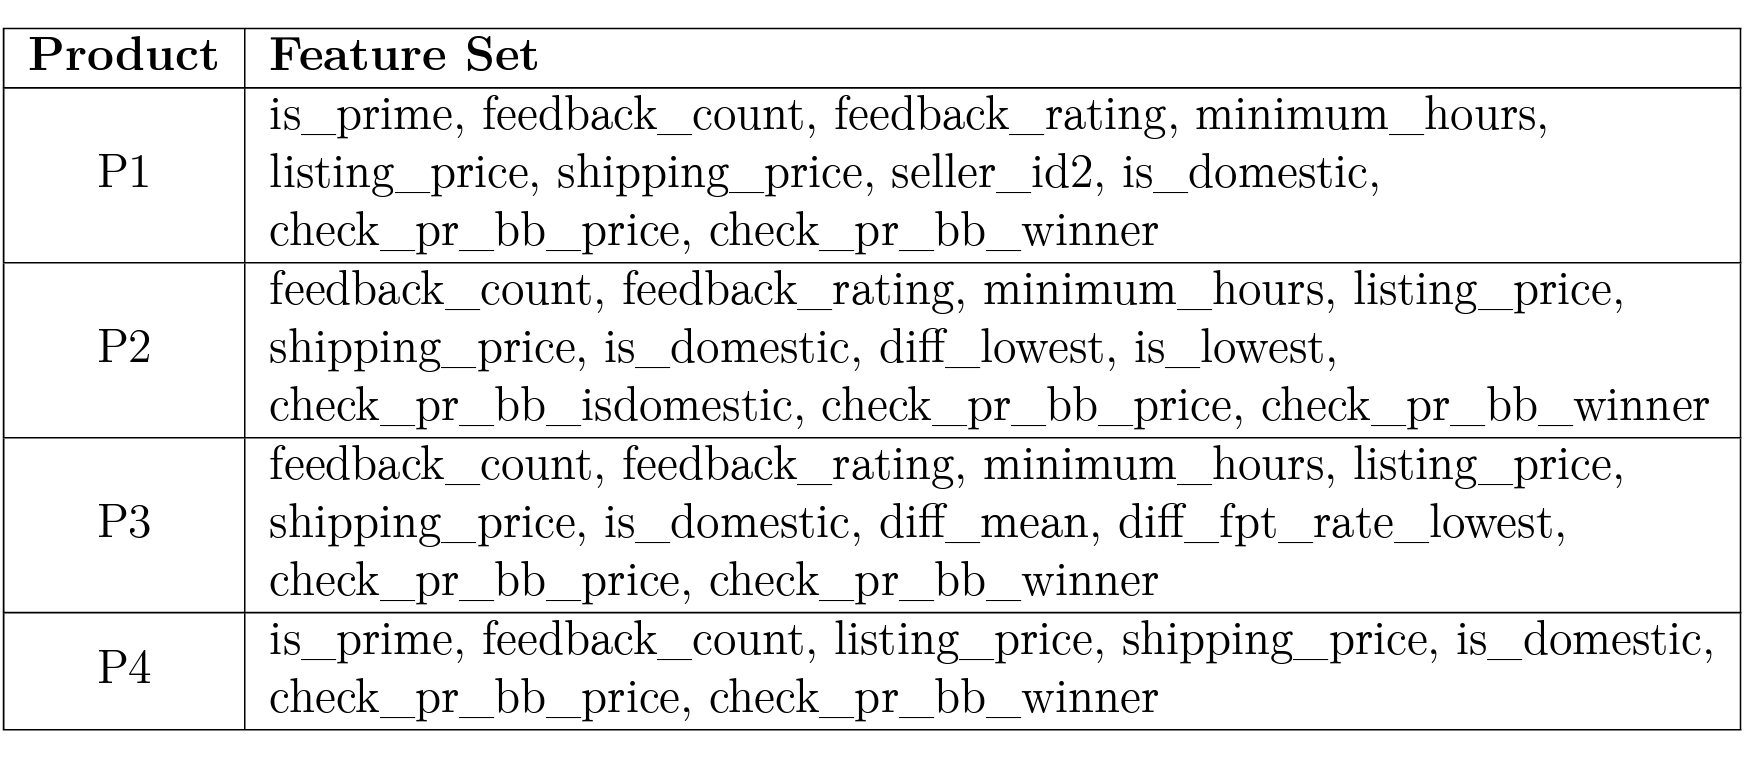

**4.My Features:  ['Sales Rank: Current', 'Sales Rank: Highest', 'Reviews: Rating', 'Reviews: Review Count',
               'Buy Box 🚚: Lowest', 'Buy Box 🚚: Stock', 'Buy Box: Is FBA',
               'Categories: Sub', 'Brand', 'Prime Eligible (Buy Box)', 'Subscribe and Save',
               'New Offer Count: Current', 'Last Price Change' 'Buy Box Seller']**

In [180]:

# Convert 'Last Price Change' to datetime and extract relevant time features
df['open_date'] = pd.to_datetime(df['open_date'])
df['Last Price Change'] = pd.to_datetime(df['Last Price Change'])
df['Price Change Month'] = df['Last Price Change'].dt.month
df['Price Change Day'] = df['Last Price Change'].dt.day

In [181]:
df.head()

ASIN  price  quantity           open_date item_is_marketplace  \
0  B091K1WBH3 36.890        11 2021-09-15 11:06:55                   y   
1  B003SLFA76 25.830         0 2021-09-18 21:21:43                   y   
2  B00RBPLLS2 26.950        18 2021-09-18 21:28:10                   y   
3  B00RBPLLQE 21.490         0 2021-09-18 21:37:26                   y   
4  B07CXDB7NK 25.850         0 2021-09-18 21:39:26                   y   

   featured_offer_buy_box_percentage  Sales Rank: Current  Reviews: Rating  \
0                             84.750            40271.000            4.700   
1                             51.820            47872.000            4.400   
2                             89.620             9085.000            4.600   
3                              0.000            61977.000            4.400   
4                             29.410             4714.000            4.700   

   Reviews: Review Count  Buy Box 🚚: Stock Buy Box: Is FBA    Brand  \
0                467.000            10.000              no  Softlan   
1                 34.000            61.000              no     HELA   
2                512.000             6.000              no     HELA   
3                250.000             0.000              no     HELA   
4                581.000             0.000              no     HELA   

  Prime Eligible (Buy Box) Subscribe and Save   Last Price Change  \
0                       no                 no 2024-01-08 23:42:00   
1                       no                 no 2024-06-03 05:48:00   
2                       no                 no 2024-05-25 05:28:00   
3                       no                 no 2024-06-03 16:46:00   
4                       no                 no 2024-04-22 04:24:00   

   Buy Box Seller  Price Change Month  Price Change Day  
0               1                   1                 8  
1               1                   6                 3  
2               1                   5                25  
3               0                   6                 3  
4               0                   4                22

In [182]:
df.shape

(412, 18)

In [183]:
df.isnull().sum()

ASIN                                 0
price                                0
quantity                             0
open_date                            0
item_is_marketplace                  0
featured_offer_buy_box_percentage    0
Sales Rank: Current                  0
Reviews: Rating                      0
Reviews: Review Count                0
Buy Box 🚚: Stock                     0
Buy Box: Is FBA                      0
Brand                                0
Prime Eligible (Buy Box)             0
Subscribe and Save                   0
Last Price Change                    0
Buy Box Seller                       0
Price Change Month                   0
Price Change Day                     0
dtype: int64

## Exploratory Data Analysis and Visualization

In [184]:
df.head(10)

ASIN  price  quantity           open_date item_is_marketplace  \
0  B091K1WBH3 36.890        11 2021-09-15 11:06:55                   y   
1  B003SLFA76 25.830         0 2021-09-18 21:21:43                   y   
2  B00RBPLLS2 26.950        18 2021-09-18 21:28:10                   y   
3  B00RBPLLQE 21.490         0 2021-09-18 21:37:26                   y   
4  B07CXDB7NK 25.850         0 2021-09-18 21:39:26                   y   
5  B01LC7T4YW 34.850         0 2021-09-23 11:43:26                   y   
6  B091K24LBS 36.890        13 2021-09-27 12:18:08                   y   
7  B091K18XYZ 33.490        19 2021-09-27 12:22:47                   y   
8  B01AY0GCOS 35.490        14 2021-09-27 13:48:43                   y   
9  B07L7PYN77  8.950        14 2021-09-28 21:48:47                   y   

   featured_offer_buy_box_percentage  Sales Rank: Current  Reviews: Rating  \
0                             84.750            40271.000            4.700   
1                             51.820            47872.000            4.400   
2                             89.620             9085.000            4.600   
3                              0.000            61977.000            4.400   
4                             29.410             4714.000            4.700   
5                              0.000            98376.000            4.400   
6                             17.860            38533.000            4.700   
7                             62.860           110079.000            4.700   
8                              0.000            13144.000            4.600   
9                             52.480            84827.000            4.600   

   Reviews: Review Count  Buy Box 🚚: Stock Buy Box: Is FBA    Brand  \
0                467.000            10.000              no  Softlan   
1                 34.000            61.000              no     HELA   
2                512.000             6.000              no     HELA   
3                250.000             0.000              no     HELA   
4                581.000             0.000              no     HELA   
5                 82.000             0.000              no  Ferrero   
6                467.000            13.000              no  Softlan   
7                 75.000            18.000              no  Softlan   
8               3380.000            14.000              no  Sidolin   
9               1183.000            14.000              no  Softlan   

  Prime Eligible (Buy Box) Subscribe and Save   Last Price Change  \
0                       no                 no 2024-01-08 23:42:00   
1                       no                 no 2024-06-03 05:48:00   
2                       no                 no 2024-05-25 05:28:00   
3                       no                 no 2024-06-03 16:46:00   
4                       no                 no 2024-04-22 04:24:00   
5                       no                 no 2024-05-02 09:08:00   
6                       no                 no 2024-06-04 10:00:00   
7                       no                 no 2024-05-28 21:48:00   
8                       no                 no 2024-06-02 06:48:00   
9                       no                 no 2024-06-04 05:26:00   

   Buy Box Seller  Price Change Month  Price Change Day  
0               1                   1                 8  
1               1                   6                 3  
2               1                   5                25  
3               0                   6                 3  
4               0                   4                22  
5               0                   5                 2  
6               1                   6                 4  
7               1                   5                28  
8               0                   6                 2  
9               1                   6                 4

In [185]:
df.columns

Index(['ASIN', 'price', 'quantity', 'open_date', 'item_is_marketplace',
       'featured_offer_buy_box_percentage', 'Sales Rank: Current',
       'Reviews: Rating', 'Reviews: Review Count', 'Buy Box 🚚: Stock',
       'Buy Box: Is FBA', 'Brand', 'Prime Eligible (Buy Box)',
       'Subscribe and Save', 'Last Price Change', 'Buy Box Seller',
       'Price Change Month', 'Price Change Day'],
      dtype='object')

In [186]:
df.shape

(412, 18)

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   ASIN                               412 non-null    object        
 1   price                              412 non-null    float64       
 2   quantity                           412 non-null    int64         
 3   open_date                          412 non-null    datetime64[ns]
 4   item_is_marketplace                412 non-null    object        
 5   featured_offer_buy_box_percentage  412 non-null    float64       
 6   Sales Rank: Current                412 non-null    float64       
 7   Reviews: Rating                    412 non-null    float64       
 8   Reviews: Review Count              412 non-null    float64       
 9   Buy Box 🚚: Stock                   412 non-null    float64       
 10  Buy Box: Is FBA                    412

In [188]:
df.describe().T

count                           mean  \
price                             412.000                         13.926   
quantity                          412.000                         32.631   
open_date                             412  2023-01-02 16:36:23.019417856   
featured_offer_buy_box_percentage 412.000                         39.550   
Sales Rank: Current               412.000                      60551.340   
Reviews: Rating                   412.000                          4.295   
Reviews: Review Count             412.000                        478.478   
Buy Box 🚚: Stock                  412.000                         71.167   
Last Price Change                     412  2024-01-30 09:00:21.262136064   
Buy Box Seller                    412.000                          0.680   
Price Change Month                412.000                          5.245   
Price Change Day                  412.000                         12.774   

                                                   min  \
price                                            2.550   
quantity                                         0.000   
open_date                          2021-09-15 11:06:55   
featured_offer_buy_box_percentage                0.000   
Sales Rank: Current                             95.000   
Reviews: Rating                                  0.000   
Reviews: Review Count                            0.000   
Buy Box 🚚: Stock                                 0.000   
Last Price Change                  2011-01-01 01:00:00   
Buy Box Seller                                   0.000   
Price Change Month                               1.000   
Price Change Day                                 1.000   

                                                             25%  \
price                                                      7.450   
quantity                                                   0.000   
open_date                          2022-04-19 10:23:24.249999872   
featured_offer_buy_box_percentage                          2.025   
Sales Rank: Current                                    11085.750   
Reviews: Rating                                            4.200   
Reviews: Review Count                                     29.750   
Buy Box 🚚: Stock                                           0.000   
Last Price Change                            2024-04-21 20:49:00   
Buy Box Seller                                             0.000   
Price Change Month                                         5.000   
Price Change Day                                           4.000   

                                                          50%  \
price                                                   9.950   
quantity                                                0.000   
open_date                          2023-01-18 12:34:58.500000   
featured_offer_buy_box_percentage                      27.390   
Sales Rank: Current                                 35185.500   
Reviews: Rating                                         4.400   
Reviews: Review Count                                  91.500   
Buy Box 🚚: Stock                                       14.000   
Last Price Change                         2024-05-29 14:04:00   
Buy Box Seller                                          1.000   
Price Change Month                                      5.000   
Price Change Day                                        8.000   

                                                             75%  \
price                                                     16.905   
quantity                                                  36.250   
open_date                          2023-09-08 20:48:41.750000128   
featured_offer_buy_box_percentage                         79.480   
Sales Rank: Current                                    81187.000   
Reviews: Rating                                            4.600   
Reviews: Review Count                                    388.250   
Buy Box 🚚: Stock 

In [189]:
df.columns.value_counts()

ASIN                                 1
price                                1
Price Change Month                   1
Buy Box Seller                       1
Last Price Change                    1
Subscribe and Save                   1
Prime Eligible (Buy Box)             1
Brand                                1
Buy Box: Is FBA                      1
Buy Box 🚚: Stock                     1
Reviews: Review Count                1
Reviews: Rating                      1
Sales Rank: Current                  1
featured_offer_buy_box_percentage    1
item_is_marketplace                  1
open_date                            1
quantity                             1
Price Change Day                     1
Name: count, dtype: int64

In [190]:
df.isnull().sum()

ASIN                                 0
price                                0
quantity                             0
open_date                            0
item_is_marketplace                  0
featured_offer_buy_box_percentage    0
Sales Rank: Current                  0
Reviews: Rating                      0
Reviews: Review Count                0
Buy Box 🚚: Stock                     0
Buy Box: Is FBA                      0
Brand                                0
Prime Eligible (Buy Box)             0
Subscribe and Save                   0
Last Price Change                    0
Buy Box Seller                       0
Price Change Month                   0
Price Change Day                     0
dtype: int64

In [191]:
df.nunique()

ASIN                                 412
price                                213
quantity                              95
open_date                            410
item_is_marketplace                    1
featured_offer_buy_box_percentage    300
Sales Rank: Current                  377
Reviews: Rating                       23
Reviews: Review Count                237
Buy Box 🚚: Stock                     138
Buy Box: Is FBA                        2
Brand                                 98
Prime Eligible (Buy Box)               2
Subscribe and Save                     2
Last Price Change                    361
Buy Box Seller                         2
Price Change Month                    12
Price Change Day                      31
dtype: int64

In [192]:
df[df['Buy Box Seller']==1]

ASIN  price  quantity           open_date item_is_marketplace  \
0    B091K1WBH3 36.890        11 2021-09-15 11:06:55                   y   
1    B003SLFA76 25.830         0 2021-09-18 21:21:43                   y   
2    B00RBPLLS2 26.950        18 2021-09-18 21:28:10                   y   
6    B091K24LBS 36.890        13 2021-09-27 12:18:08                   y   
7    B091K18XYZ 33.490        19 2021-09-27 12:22:47                   y   
9    B07L7PYN77  8.950        14 2021-09-28 21:48:47                   y   
10   B08FGTMDGD 21.890        23 2021-10-08 17:26:48                   y   
11   B08X1BNRZ3 14.950         0 2021-10-08 17:58:05                   y   
13   B007N30XDQ  8.490         0 2021-10-19 12:28:12                   y   
14   B085WK5TD9  8.900         8 2021-10-29 21:37:49                   y   
15   B084P7TQTX 13.950        70 2021-10-29 21:49:32                   y   
16   B084Q6K38Q 24.000        73 2021-10-29 21:54:08                   y   
19   B001N3EU8Q  5.290         0 2021-11-04 17:13:43                   y   
29   B073ZBD2G8  8.420         0 2021-12-09 22:35:41                   y   
32   B071YM39PX  9.490         0 2021-12-20 20:42:13                   y   
33   B00IQ08GEI  6.490        29 2021-12-23 23:28:26                   y   
34   B008RWPBWA 19.890        47 2021-12-25 22:34:28                   y   
35   B00EVMIXCU 19.490         0 2021-12-25 22:45:23                   y   
36   B00EVMIYDI 16.950         0 2021-12-25 22:47:47                   y   
37   B00PP0STNA  8.390         0 2021-12-27 20:37:04                   y   
38   B00PQRSWWA  7.950         0 2021-12-27 20:42:37                   y   
39   B00QVD6EFU  6.500         0 2021-12-27 20:50:33                   y   
40   B01N90254W  8.850         0 2021-12-27 20:54:16                   y   
41   B017RJUPZ6 14.350         0 2021-12-27 20:57:37                   y   
42   B00RBQ9KN4 17.890         0 2021-12-27 21:03:28                   y   
45   B00RBPLLM8 27.950        17 2021-12-30 13:56:32                   y   
46   B004NPBMDC 27.950        25 2022-01-04 16:49:03                   y   
47   B08X1DPX9T 13.160         0 2022-01-04 22:41:45                   y   
52   B07XYY941C  8.950         0 2022-01-11 22:49:50                   y   
53   B00VFYQZYU  6.990         0 2022-01-11 22:54:27                   y   
54   B00TFAQS3O  7.490         0 2022-01-11 23:01:31                   y   
55   B00HWTD41O  7.290         0 2022-01-11 23:04:00                   y   
56   B00HWTAC5A  7.390         0 2022-01-11 23:05:40                   y   
57   B091B3HK4S 22.490         0 2022-01-12 13:19:11                   y   
58   B07L7R5PWV  8.690        92 2022-01-12 19:44:55                   y   
62   B004YXNJB6  5.590        92 2022-01-14 21:58:48                   y   
63   B00IMM8PIC  6.890         0 2022-01-14 22:09:48                   y   
67   B000TDA49U 23.790         0 2022-01-19 19:34:56                   y   
68   B004V2RUE2 13.490         0 2022-01-21 09:40:36                   y   
69   B00DRG7FG6 12.390        36 2022-01-21 10:06:42                   y   
70   B005UMQEB2 11.390        20 2022-01-21 10:08:47                   y   
71   B003TKYZKY  9.800         6 2022-01-30 21:47:21                   y   
72   B001PSMKAY  8.980         0 2022-02-01 21:52:23                   y   
73   B00E2TNBTW 14.290        40 2022-02-04 21:36:38                   y   
74   B003D0YN9I  9.890       103 2022-02-04 21:49:28                   y   
76   B00STQ1682 19.790        46 2022-02-17 13:25:48                   y   
83   B00561GPB6 33.490         0 2022-02-25 23:13:24                   y   
92   B004YXNHD6  5.290        90 2022-03-03 20:56:36                   y   
96   B00R0SXFDE  8.030         0 2022-04-13 10:38:07                   y   
97   B009K42L7W  5.890        37 2022-04-15 19:43:14                   y   
98   B09WMZHB97  5.990        10 2022-04-15 19:46:46                   y   
100  B00IQ1LDFG  4.970        28 2022-04-15 19:56:20       

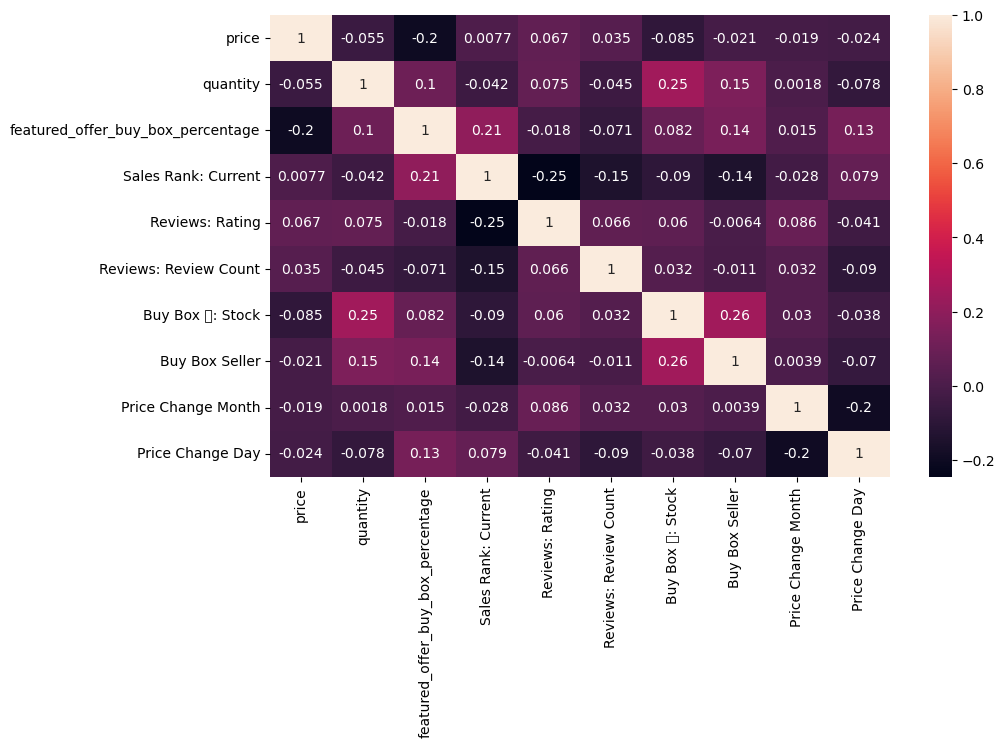

In [193]:
sns.heatmap(df.select_dtypes(include="number").corr(), annot=True);

In [194]:
df['Buy Box Seller'].value_counts()

Buy Box Seller
1    280
0    132
Name: count, dtype: int64

In [195]:
df['Buy Box Seller'].value_counts(normalize=True)

Buy Box Seller
1   0.680
0   0.320
Name: proportion, dtype: float64

In [196]:
# Drop the 'open_date' column from the DataFrame
df.drop(columns=['open_date'], inplace=True)

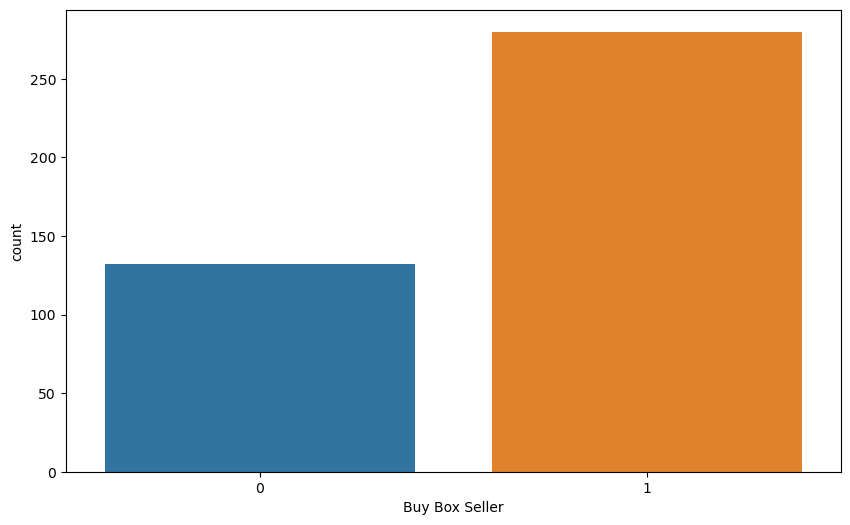

In [197]:
sns.countplot(data = df, x = "Buy Box Seller");

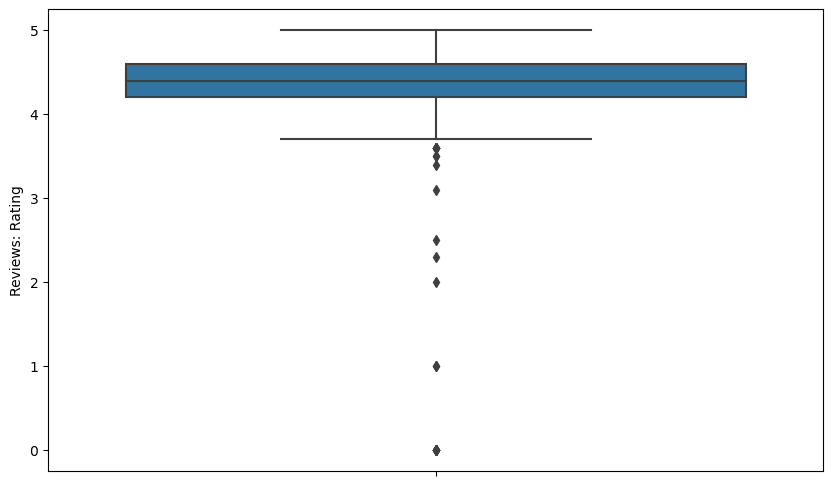

In [198]:
sns.boxplot(data =df, y="Reviews: Rating");

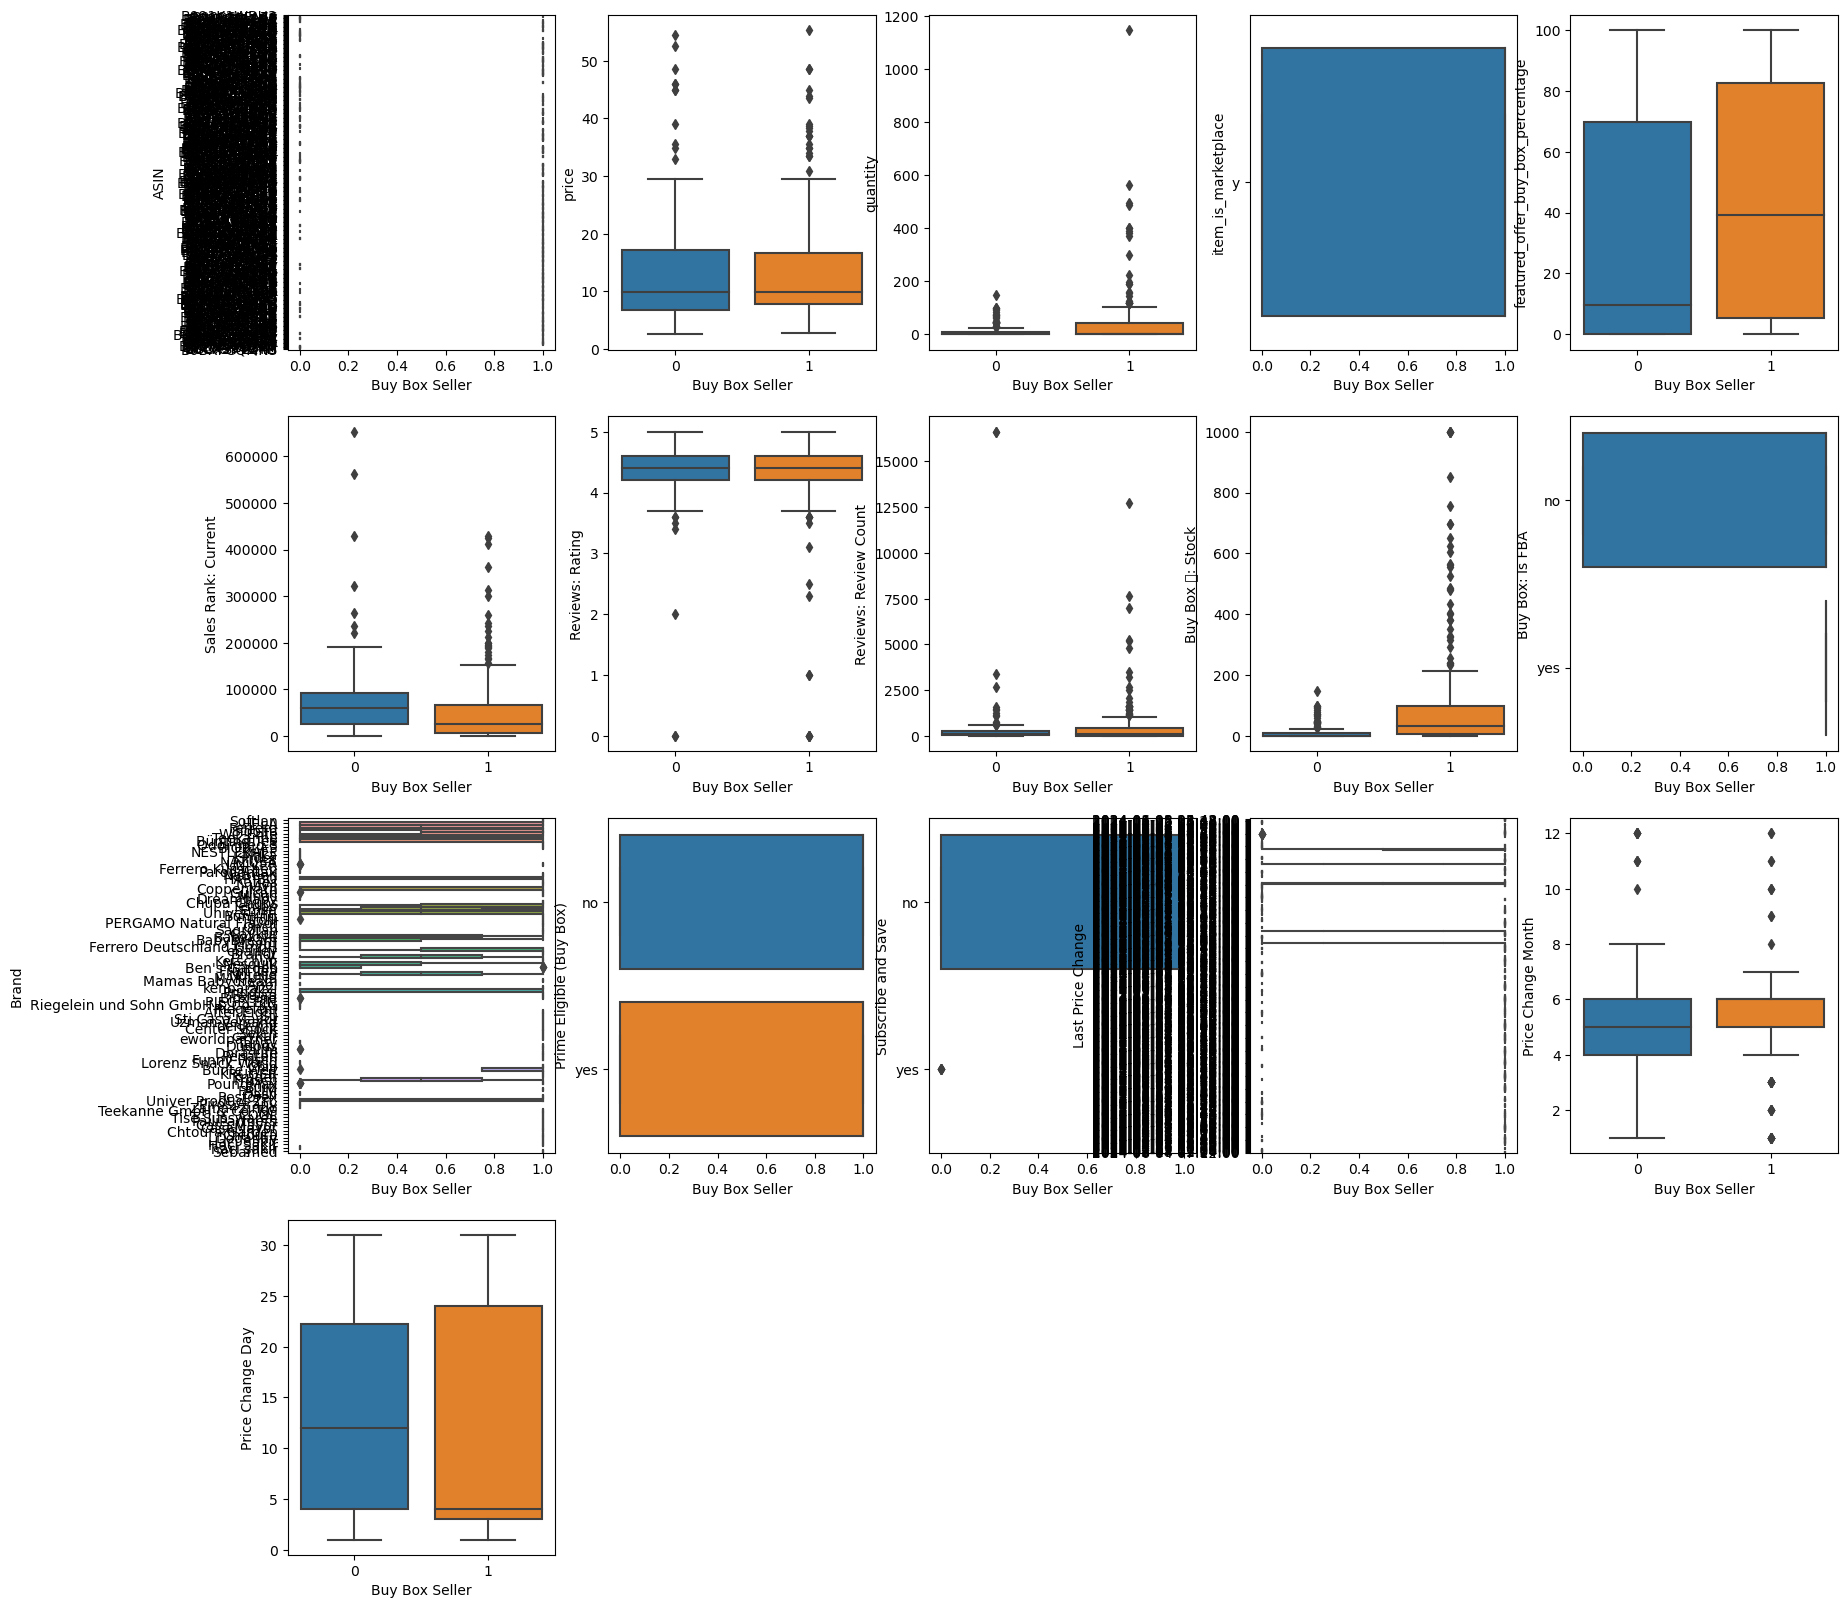

In [199]:
index = 0
plt.figure(figsize=(20,20))
for feature in df.columns:
    if feature != "Buy Box Seller":
        index += 1
        plt.subplot(4,5,index)
        sns.boxplot(x='Buy Box Seller',y=feature,data=df)
plt.show()

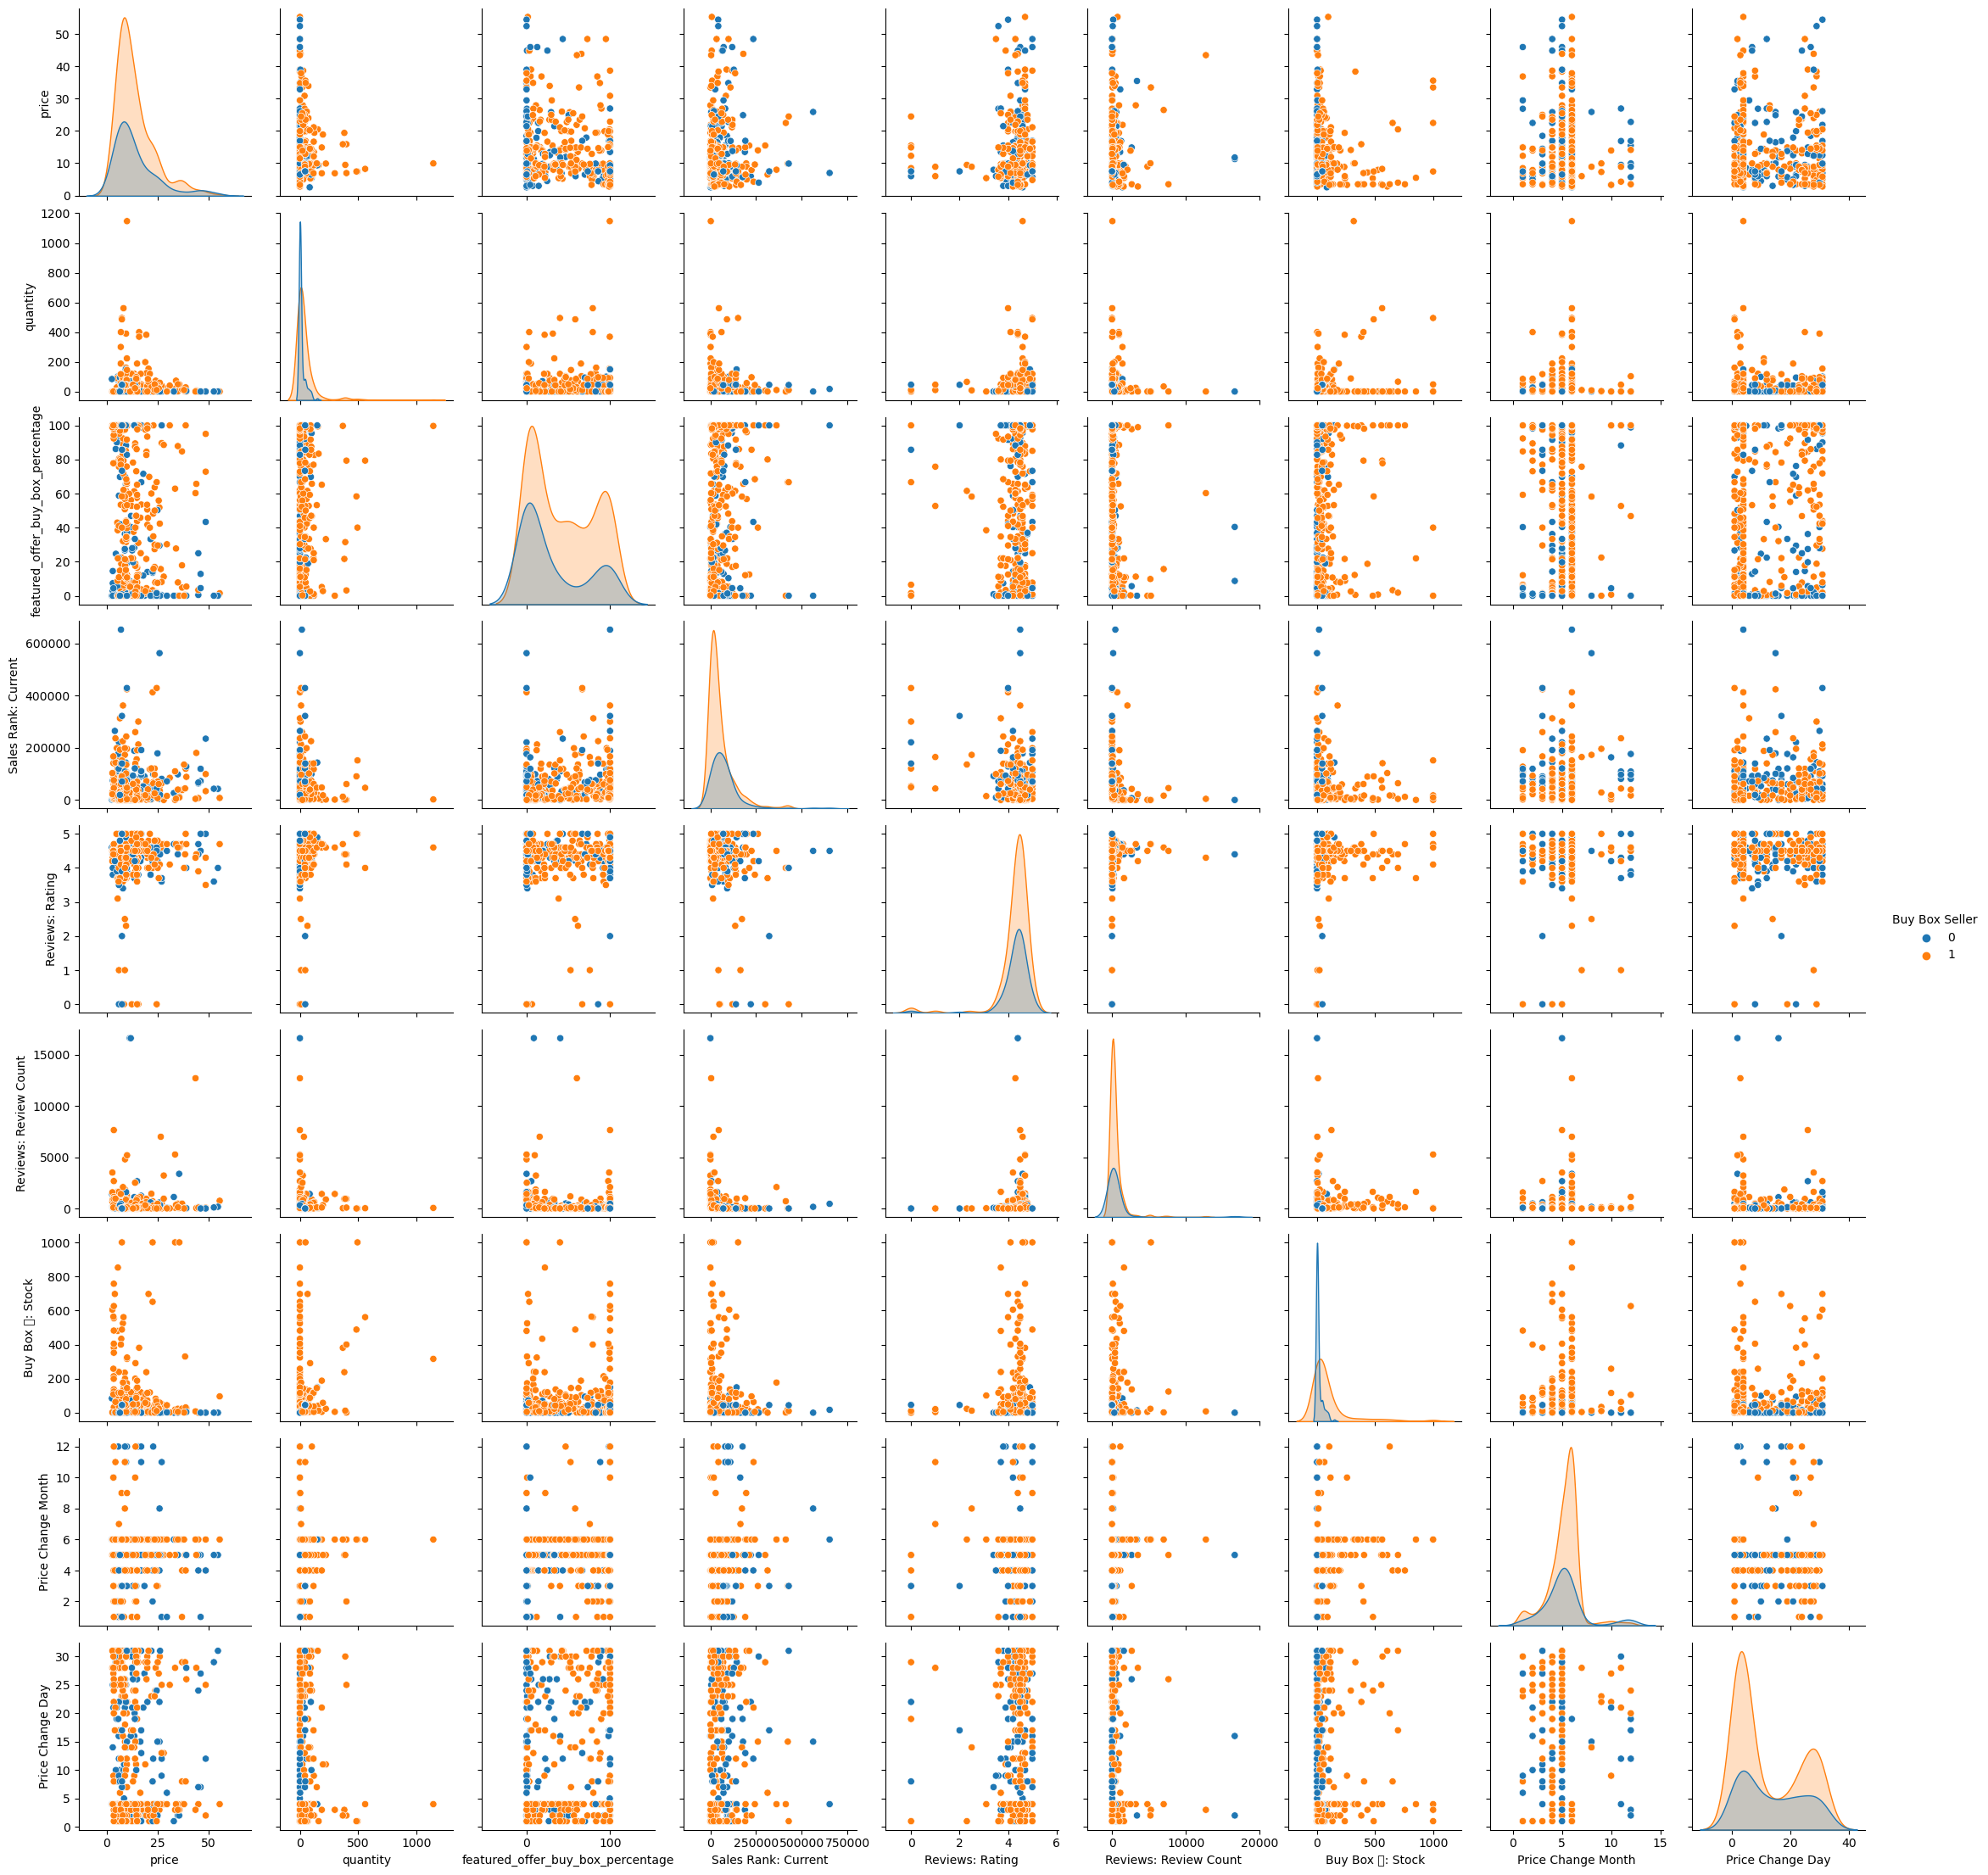

In [200]:
sns.pairplot(df, hue = "Buy Box Seller");

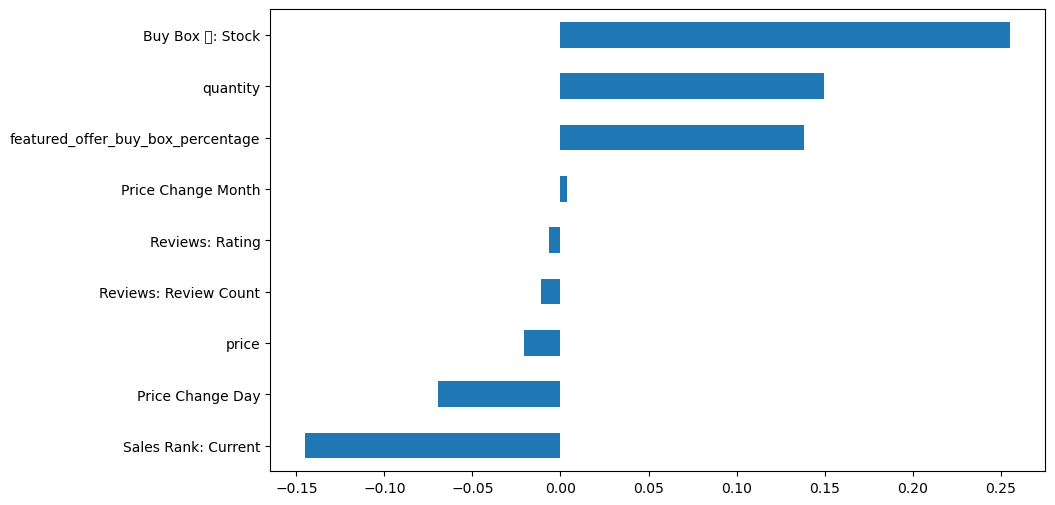

In [201]:
df.select_dtypes('number').corr()["Buy Box Seller"].drop("Buy Box Seller").sort_values().plot.barh();

In [202]:
df.drop(columns=['ASIN', 'item_is_marketplace', 'Last Price Change', 'featured_offer_buy_box_percentage'], axis=1, inplace=True)

In [203]:
df.head()

price  quantity  Sales Rank: Current  Reviews: Rating  \
0 36.890        11            40271.000            4.700   
1 25.830         0            47872.000            4.400   
2 26.950        18             9085.000            4.600   
3 21.490         0            61977.000            4.400   
4 25.850         0             4714.000            4.700   

   Reviews: Review Count  Buy Box 🚚: Stock Buy Box: Is FBA    Brand  \
0                467.000            10.000              no  Softlan   
1                 34.000            61.000              no     HELA   
2                512.000             6.000              no     HELA   
3                250.000             0.000              no     HELA   
4                581.000             0.000              no     HELA   

  Prime Eligible (Buy Box) Subscribe and Save  Buy Box Seller  \
0                       no                 no               1   
1                       no                 no               1   
2                       no                 no               1   
3                       no                 no               0   
4                       no                 no               0   

   Price Change Month  Price Change Day  
0                   1                 8  
1                   6                 3  
2                   5                25  
3                   6                 3  
4                   4                22

In [204]:
df.drop("Brand", axis=1, inplace=True)

In [205]:
df_ = df.copy()

## Train | Test Split and Scaling

In [206]:
X = df.drop(["Buy Box Seller"], axis = 1)
y = df["Buy Box Seller"]

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.10,
                                                    stratify=y,
                                                    random_state = 42)

In [208]:
X_train['Prime Eligible (Buy Box)'].value_counts()

Prime Eligible (Buy Box)
no     233
yes    137
Name: count, dtype: int64

In [209]:
X_train['Subscribe and Save'].unique()

array(['no', 'yes'], dtype=object)

In [210]:
y_train.nunique()

2

In [211]:
X_train.select_dtypes(object).columns

Index(['Buy Box: Is FBA', 'Prime Eligible (Buy Box)', 'Subscribe and Save'], dtype='object')

# Logistic Regression

In [213]:
column_trans = make_column_transformer((OneHotEncoder(handle_unknown="ignore",drop="first",
                                                     sparse_output=False),
                                        ['Buy Box: Is FBA','Prime Eligible (Buy Box)', 'Subscribe and Save']),

                                        remainder=StandardScaler())


operations = [('column_trans',column_trans),('log_model', LogisticRegression(random_state=42))]
log_pipe = Pipeline(steps= operations)



In [214]:
log_pipe.fit(X_train, y_train)

Pipeline(steps=[('column_trans',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Buy Box: Is FBA',
                                                   'Prime Eligible (Buy Box)',
                                                   'Subscribe and Save'])])),
                ('log_model', LogisticRegression(random_state=42))])

In [228]:
y_pred = log_pipe.predict(X_test)
y_pred_proba = log_pipe.predict_proba(X_test)

In [229]:
test_data = pd.concat([X_test, y_test], axis = 1)
test_data["pred"] = y_pred
test_data["pred_proba"] = y_pred_proba[:, 1]
test_data.sample(5)

price  quantity  Sales Rank: Current  Reviews: Rating  \
327  3.490         0            45823.000            4.500   
383  9.000        50            20059.000            4.300   
359 24.920        29             7339.000            4.800   
27   7.890         0            67364.000            4.500   
388  9.400        56            48362.000            4.500   

     Reviews: Review Count  Buy Box 🚚: Stock Buy Box: Is FBA  \
327               7643.000           124.000             yes   
383                149.000            15.000              no   
359                449.000            39.000              no   
27                 142.000             0.000              no   
388                101.000             9.000              no   

    Prime Eligible (Buy Box) Subscribe and Save  Price Change Month  \
327                      yes                 no                   5   
383                       no                 no                   6   
359                       no                 no                   6   
27                       yes                 no                   3   
388                       no                 no                   6   

     Price Change Day  Buy Box Seller  pred  pred_proba  
327                26               1     1       0.942  
383                 4               1     1       0.652  
359                 4               1     1       0.754  
27                 23               0     0       0.135  
388                 1               1     1       0.626

In [230]:
from sklearn.metrics import confusion_matrix, classification_report

In [231]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)

    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [232]:
eval_metric(log_pipe, X_train, y_train, X_test, y_test)

Test_Set
[[ 8  5]
 [ 6 23]]
              precision    recall  f1-score   support

           0       0.57      0.62      0.59        13
           1       0.82      0.79      0.81        29

    accuracy                           0.74        42
   macro avg       0.70      0.70      0.70        42
weighted avg       0.74      0.74      0.74        42


Train_Set
[[ 66  53]
 [ 19 232]]
              precision    recall  f1-score   support

           0       0.78      0.55      0.65       119
           1       0.81      0.92      0.87       251

    accuracy                           0.81       370
   macro avg       0.80      0.74      0.76       370
weighted avg       0.80      0.81      0.80       370



In [233]:
y_pred = log_pipe.predict(X_test)
log_f1 = f1_score(y_test, y_pred)
log_accuracy = accuracy_score(y_test, y_pred)

## With Smote

In [126]:
from sklearn.impute import SimpleImputer


# Define the pipeline operations
operations = [
    ('preprocessor', column_trans),
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('log_model', LogisticRegression(random_state=42))
]

# Create the pipeline
log_pipe_smote = Pipeline(steps=operations)

# Fit the model
log_pipe_smote.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Buy Box: Is FBA',
                                                   'Prime Eligible (Buy Box)',
                                                   'Subscribe and Save']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Brand'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
                ('log_model', LogisticRegression(random_state=42))])

In [127]:
eval_metric(log_pipe_smote, X_train, y_train, X_test, y_test)

Test_Set
[[12  1]
 [14 15]]
              precision    recall  f1-score   support

           0       0.46      0.92      0.62        13
           1       0.94      0.52      0.67        29

    accuracy                           0.64        42
   macro avg       0.70      0.72      0.64        42
weighted avg       0.79      0.64      0.65        42


Train_Set
[[102  17]
 [ 58 193]]
              precision    recall  f1-score   support

           0       0.64      0.86      0.73       119
           1       0.92      0.77      0.84       251

    accuracy                           0.80       370
   macro avg       0.78      0.81      0.78       370
weighted avg       0.83      0.80      0.80       370



## Cross Validate

In [128]:
from sklearn.model_selection import cross_validate

model = log_pipe_smote

scores = cross_validate(model, X_train, y_train, scoring = ["precision",
                                                                   "recall",
                                                                   "f1",
                                                                   "accuracy"], cv = 10)

df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores

fit_time  score_time  test_precision  test_recall  test_f1  test_accuracy
1      0.018       0.004           0.882        0.600    0.714          0.676
2      0.010       0.006           0.833        0.800    0.816          0.757
3      0.011       0.005           0.778        0.560    0.651          0.595
4      0.010       0.004           0.947        0.720    0.818          0.784
5      0.008       0.003           0.864        0.760    0.809          0.757
6      0.007       0.003           0.909        0.800    0.851          0.811
7      0.007       0.003           0.885        0.920    0.902          0.865
8      0.007       0.003           0.870        0.800    0.833          0.784
9      0.007       0.003           0.950        0.760    0.844          0.811
10     0.007       0.003           0.947        0.692    0.800          0.757

In [129]:
df_scores.mean()[2:]

test_precision   0.887
test_recall      0.741
test_f1          0.804
test_accuracy    0.759
dtype: float64

## GridSearchCV

In [130]:
from sklearn.model_selection import GridSearchCV

In [131]:
# Define parameter grid for GridSearchCV
param_grid = {
    'log_model__C': [0.1, 1, 10, 100],
    'log_model__solver': ['liblinear', 'saga']
}

# Create GridSearchCV
grid_model = GridSearchCV(estimator=log_pipe, param_grid=param_grid, cv=5, scoring='f1', verbose=1)

# Fit the model
grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_trans',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Buy '
                                                                          'Box: '
                                                                          'Is '
                                                                          'FBA',
                                                                          'Prime '
                                                                          'Eligible '
                                                                          '(Buy '
                                                                          'Box)',
                                                                          'Subscribe '
                                                                          'and '
                                                                          'Save']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Brand'])])),
                                       ('log_model',
                                        LogisticRegression(random_state=42))]),
             param_grid={'log_model__C': [0.1, 1, 10, 100],
                         'log_model__solver': ['liblinear', 'saga']},
             scoring='f1', verbose=1)

In [132]:
grid_model.best_params_

{'log_model__C': 10, 'log_model__solver': 'liblinear'}

In [133]:
eval_metric(grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[ 9  4]
 [ 8 21]]
              precision    recall  f1-score   support

           0       0.53      0.69      0.60        13
           1       0.84      0.72      0.78        29

    accuracy                           0.71        42
   macro avg       0.68      0.71      0.69        42
weighted avg       0.74      0.71      0.72        42


Train_Set
[[ 76  43]
 [ 19 232]]
              precision    recall  f1-score   support

           0       0.80      0.64      0.71       119
           1       0.84      0.92      0.88       251

    accuracy                           0.83       370
   macro avg       0.82      0.78      0.80       370
weighted avg       0.83      0.83      0.83       370



## Best Score

In [134]:
grid_model.best_score_

0.8518718395887955

## ROC (Receiver Operating Curve) and AUC (Area Under Curve)

In [135]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve, roc_auc_score, auc, roc_curve, average_precision_score

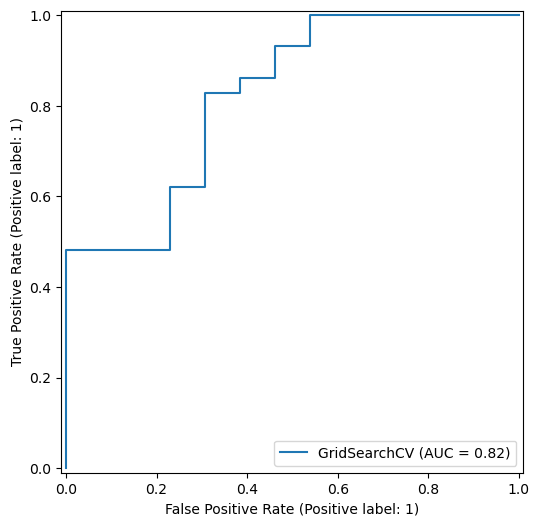

In [136]:
RocCurveDisplay.from_estimator(grid_model, X_test, y_test);

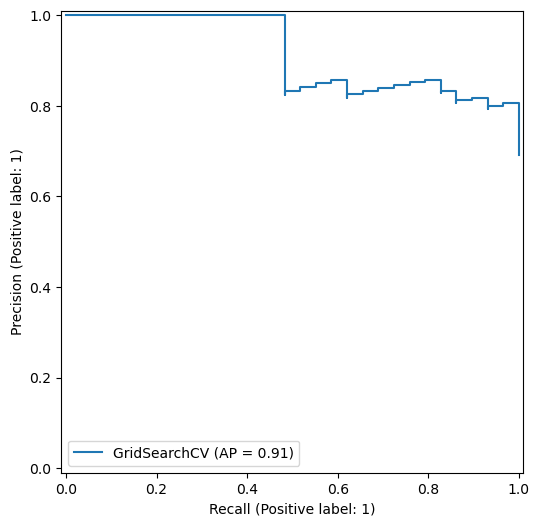

In [137]:
PrecisionRecallDisplay.from_estimator(grid_model, X_test, y_test);

In [138]:
y_pred_proba = grid_model.predict_proba(X_train)
roc_auc_score(y_train, y_pred_proba[:, 1])

0.9014697512471125

In [139]:
fp_rate, tp_rate, tresholds = roc_curve(y_train, y_pred_proba[:, 1])

In [140]:
fp_tp_th = fp_rate, tp_rate, tresholds = roc_curve(y_train, y_pred_proba[:, 1])
df_fp_tp_th = pd.DataFrame(fp_tp_th)
df_fp_tp_th

0     1     2     3     4     5     6     7     8     9     10    11  \
0 0.000 0.000 0.000 0.017 0.017 0.025 0.025 0.034 0.034 0.042 0.042 0.050   
1 0.000 0.004 0.450 0.450 0.498 0.498 0.598 0.598 0.602 0.602 0.614 0.614   
2   inf 1.000 0.948 0.946 0.900 0.895 0.798 0.798 0.796 0.795 0.788 0.786   

     12    13    14    15    16    17    18    19    20    21    22    23  \
0 0.050 0.076 0.076 0.084 0.084 0.101 0.101 0.118 0.118 0.126 0.126 0.143   
1 0.661 0.661 0.669 0.669 0.681 0.681 0.693 0.693 0.709 0.709 0.725 0.725   
2 0.771 0.766 0.765 0.753 0.749 0.745 0.744 0.736 0.733 0.728 0.711 0.703   

     24    25    26    27    28    29    30    31    32    33    34    35  \
0 0.143 0.151 0.151 0.160 0.160 0.168 0.168 0.176 0.176 0.185 0.185 0.193   
1 0.733 0.733 0.749 0.749 0.753 0.753 0.765 0.765 0.777 0.777 0.801 0.801   
2 0.701 0.699 0.691 0.688 0.683 0.682 0.679 0.675 0.670 0.670 0.654 0.651   

     36    37    38    39    40    41    42    43    44    45    46    47  \
0 0.193 0.210 0.210 0.218 0.218 0.227 0.227 0.269 0.269 0.277 0.277 0.294   
1 0.821 0.821 0.829 0.829 0.833 0.833 0.845 0.845 0.857 0.857 0.865 0.865   
2 0.635 0.632 0.628 0.624 0.624 0.624 0.622 0.605 0.596 0.593 0.587 0.578   

     48    49    50    51    52    53    54    55    56    57    58    59  \
0 0.294 0.303 0.303 0.311 0.311 0.328 0.328 0.345 0.345 0.353 0.353 0.361   
1 0.876 0.876 0.884 0.884 0.888 0.888 0.892 0.892 0.916 0.916 0.920 0.920   
2 0.576 0.575 0.562 0.560 0.555 0.550 0.549 0.544 0.520 0.511 0.509 0.505   

     60    61    62    63    64    65    66    67    68    69    70    71  \
0 0.361 0.395 0.395 0.403 0.403 0.420 0.420 0.429 0.429 0.437 0.437 0.445   
1 0.924 0.924 0.932 0.932 0.940 0.940 0.952 0.952 0.956 0.956 0.960 0.960   
2 0.505 0.489 0.474 0.471 0.468 0.458 0.447 0.446 0.440 0.422 0.419 0.417   

     72    73    74    75    76    77    78    79    80    81    82    83  \
0 0.445 0.496 0.496 0.504 0.504 0.529 0.529 0.613 0.613 0.630 0.630 0.739   
1 0.964 0.964 0.968 0.968 0.972 0.972 0.976 0.976 0.984 0.984 0.992 0.992   
2 0.416 0.379 0.375 0.375 0.345 0.313 0.309 0.259 0.243 0.217 0.207 0.123   

     84    85    86    87  
0 0.739 0.782 0.782 1.000  
1 0.996 0.996 1.000 1.000  
2 0.114 0.092 0.090 0.009

In [141]:
optimal_idx = np.argmax(tp_rate - fp_rate)
optimal_treshold = tresholds[optimal_idx]
optimal_treshold

0.6354792820323009

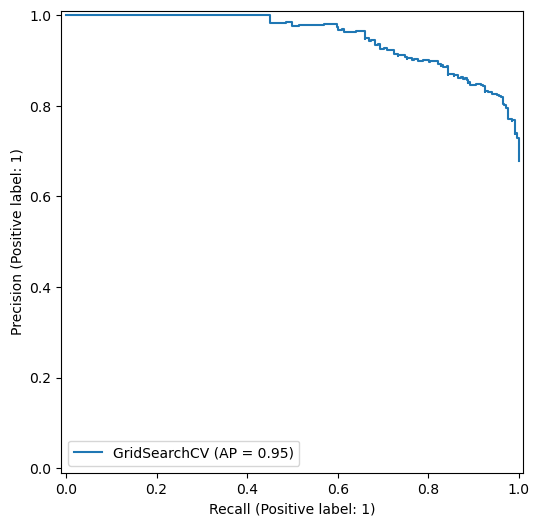

In [142]:
PrecisionRecallDisplay.from_estimator(grid_model, X_train, y_train);

In [143]:
y_pred_proba = grid_model.predict_proba(X_train)
average_precision_score(y_train, y_pred_proba[:, 1])

0.9523877524571315

In [144]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_pred_proba[:, 1])

In [145]:
optimal_idx = np.argmax((2 * precisions * recalls) / (precisions + recalls)) #buda formülü aslında f1 skorun formülü
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.4155796596275868

In [146]:
y_pred2 = pd.Series(grid_model.predict_proba(X_test)[:,1]).apply(lambda x : 1 if x >= optimal_threshold else 0)

In [147]:
print(confusion_matrix(y_test,y_pred2))
print(classification_report(y_test,y_pred2))

[[ 8  5]
 [ 4 25]]
              precision    recall  f1-score   support

           0       0.67      0.62      0.64        13
           1       0.83      0.86      0.85        29

    accuracy                           0.79        42
   macro avg       0.75      0.74      0.74        42
weighted avg       0.78      0.79      0.78        42



In [148]:
from ipywidgets import interactive, FloatSlider
from IPython.display import display

In [149]:
y_pred = grid_model.predict(X_test)
y_pred_proba = grid_model.predict_proba(X_test)

In [150]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from sklearn.model_selection import StratifiedKFold
def CV(n, est, X, y, optimal_threshold):
    skf = StratifiedKFold(n_splits = n, shuffle = True, random_state = 42)
    acc_scores = []
    pre_scores = []
    rec_scores = []
    f1_scores  = []
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    for train_index, test_index in skf.split(X, y):
        X_train = X.loc[train_index]
        y_train = y.loc[train_index]
        X_test = X.loc[test_index]
        y_test = y.loc[test_index]
        est = est
        est.fit(X_train, y_train)
        y_pred = est.predict(X_test)
        y_pred_proba = est.predict_proba(X_test)
        y_pred2 = pd.Series(y_pred_proba[:,1]).apply(lambda x : 1 if x >= optimal_threshold else 0)
        acc_scores.append(accuracy_score(y_test, y_pred2))
        pre_scores.append(precision_score(y_test, y_pred2, pos_label=1))
        rec_scores.append(recall_score(y_test, y_pred2, pos_label=1))
        f1_scores.append(f1_score(y_test, y_pred2, pos_label=1))
    print(f'Accuracy {np.mean(acc_scores)*100:>10,.2f}%  std {np.std(acc_scores)*100:.2f}%')
    print(f'Precision-1 {np.mean(pre_scores)*100:>7,.2f}%  std {np.std(pre_scores)*100:.2f}%')
    print(f'Recall-1 {np.mean(rec_scores)*100:>10,.2f}%  std {np.std(rec_scores)*100:.2f}%')
    print(f'F1_score-1 {np.mean(f1_scores)*100:>8,.2f}%  std {np.std(f1_scores)*100:.2f}%')

In [151]:
# Define the pipeline operations
operations = [
    ('preprocessor', column_trans),
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('log_model', LogisticRegression(random_state=42))
]

# Create the pipeline
log_pipe_smote = Pipeline(steps=operations)

# Fit the model
log_pipe_smote.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Buy Box: Is FBA',
                                                   'Prime Eligible (Buy Box)',
                                                   'Subscribe and Save']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Brand'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
                ('log_model', LogisticRegression(random_state=42))])

In [152]:
y_pred = log_pipe_smote.predict(X_test)
log_f1_smote = f1_score(y_test, y_pred)
log_accuracy_smote = accuracy_score(y_test, y_pred)

# Random Forest

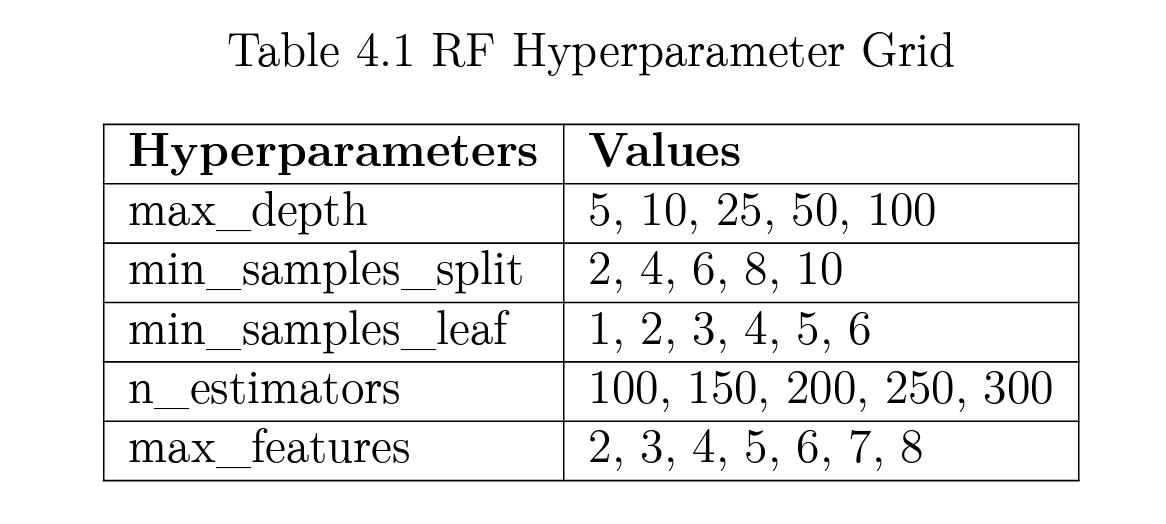

In [153]:
operations = [('column_trans',column_trans),('RF_model', RandomForestClassifier(random_state=42))]
RF_pipe = Pipeline(steps= operations)

RF_pipe.fit(X_train, y_train)

Pipeline(steps=[('column_trans',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Buy Box: Is FBA',
                                                   'Prime Eligible (Buy Box)',
                                                   'Subscribe and Save']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Brand'])])),
                ('RF_model', RandomForestClassifier(random_state=42))])

In [154]:
eval_metric(RF_pipe, X_train, y_train, X_test, y_test)

Test_Set
[[13  0]
 [ 4 25]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.87        13
           1       1.00      0.86      0.93        29

    accuracy                           0.90        42
   macro avg       0.88      0.93      0.90        42
weighted avg       0.93      0.90      0.91        42


Train_Set
[[119   0]
 [  0 251]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00       251

    accuracy                           1.00       370
   macro avg       1.00      1.00      1.00       370
weighted avg       1.00      1.00      1.00       370



## CV

In [155]:
operations = [('column_trans',column_trans), ('RF_model', RandomForestClassifier(random_state=101))]
RF_pipe = Pipeline(steps= operations)

scores = cross_validate(RF_pipe, X_train, y_train, scoring = ["accuracy", "precision", "recall", "f1"],
                        cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy     0.897
train_accuracy    1.000
test_precision    0.919
train_precision   1.000
test_recall       0.932
train_recall      1.000
test_f1           0.925
train_f1          1.000
dtype: float64

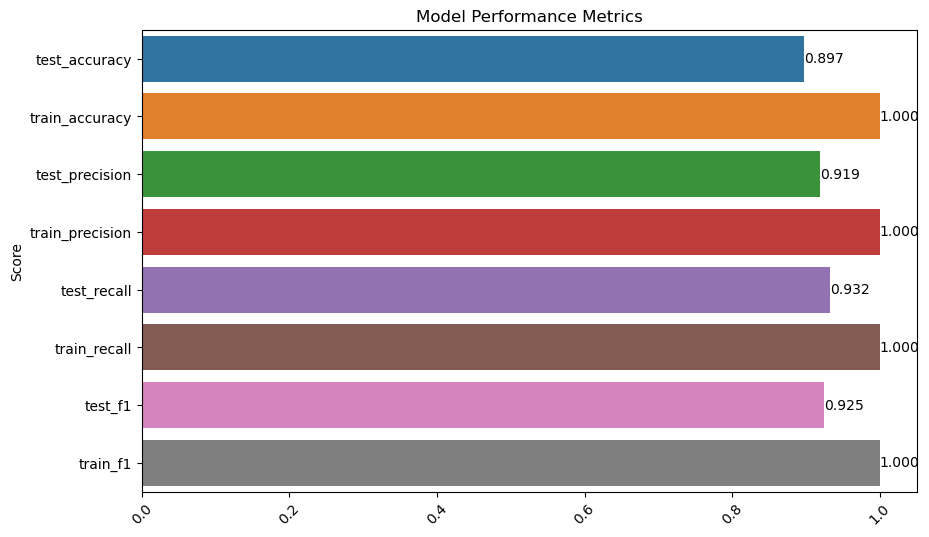

In [156]:
mean_scores = pd.DataFrame(scores).mean()[2:]

plt.figure(figsize=(10, 6))
ax = sns.barplot(y=mean_scores.index, x=mean_scores.values)
ax.bar_label(ax.containers[0], fmt='%.3f')
plt.xticks(rotation=45)
plt.ylabel('Score')
plt.title('Model Performance Metrics');

In [157]:
RF_pipe.get_params()

{'memory': None,
 'steps': [('column_trans',
   ColumnTransformer(remainder=StandardScaler(),
                     transformers=[('onehotencoder',
                                    OneHotEncoder(drop='first',
                                                  handle_unknown='ignore',
                                                  sparse_output=False),
                                    ['Buy Box: Is FBA', 'Prime Eligible (Buy Box)',
                                     'Subscribe and Save']),
                                   ('ordinalencoder',
                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                   unknown_value=-1),
                                    ['Brand'])])),
  ('RF_model', RandomForestClassifier(random_state=101))],
 'verbose': False,
 'column_trans': ColumnTransformer(remainder=StandardScaler(),
                   transformers=[('onehotencoder',
                                  OneHotEnc

## Grid Search

In [158]:
param_grid = {'RF_model__n_estimators':[64,100, 128],
             'RF_model__max_features':[4, 'sqrt'],
             'RF_model__max_depth':[2, 3, 4, 5, None],
             'RF_model__min_samples_split':[2,4],
             'RF_model__min_samples_leaf': [2,3,4],
             'RF_model__max_samples':[0.8, 1, None]}

In [159]:
operations = [('column_trans',column_trans), ('RF_model', RandomForestClassifier(random_state=101))]
RF_pipe = Pipeline(steps= operations)

RF_grid = GridSearchCV(RF_pipe, param_grid, scoring = "f1", n_jobs = -1)

RF_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('column_trans',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Buy '
                                                                          'Box: '
                                                                          'Is '
                                                                          'FBA',
                                                                          'Prime '
                                                                          'Eligible '
                                                                          '(Buy '
                                                                          'Box)',
                                                                          'Subscribe '
                                                                          'and '
                                                                          'Save']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Brand'])])),
                                       ('RF_model',
                                        RandomForestClassifier(random_state=101))]),
             n_jobs=-1,
             param_grid={'RF_model__max_depth': [2, 3, 4, 5, None],
                         'RF_model__max_features': [4, 'sqrt'],
                         'RF_model__max_samples': [0.8, 1, None],
                         'RF_model__min_samples_leaf': [2, 3, 4],
                         'RF_model__min_samples_split': [2, 4],
                         'RF_model__n_estimators': [64, 100, 128]},
             scoring='f1')

In [160]:
eval_metric(RF_grid, X_train, y_train, X_test, y_test)

Test_Set
[[13  0]
 [ 4 25]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.87        13
           1       1.00      0.86      0.93        29

    accuracy                           0.90        42
   macro avg       0.88      0.93      0.90        42
weighted avg       0.93      0.90      0.91        42


Train_Set
[[117   2]
 [  1 250]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       119
           1       0.99      1.00      0.99       251

    accuracy                           0.99       370
   macro avg       0.99      0.99      0.99       370
weighted avg       0.99      0.99      0.99       370



In [161]:
RF_grid.best_params_

{'RF_model__max_depth': None,
 'RF_model__max_features': 4,
 'RF_model__max_samples': None,
 'RF_model__min_samples_leaf': 2,
 'RF_model__min_samples_split': 2,
 'RF_model__n_estimators': 64}

In [162]:
operations = [
    ('preprocessor', column_trans),
    ('RF_model', RandomForestClassifier(max_depth=None,
                                        max_features=4,
                                        max_samples=None,
                                        min_samples_leaf=2,
                                        min_samples_split=2,
                                        n_estimators=64))]
RF_pipe = Pipeline(steps= operations)
RF_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Buy Box: Is FBA',
                                                   'Prime Eligible (Buy Box)',
                                                   'Subscribe and Save']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Brand'])])),
                ('RF_model',
                 RandomForestClassifier(max_features=4, min_samples_leaf=2,
                                        n_estimators=64))])

In [163]:
y_pred = RF_pipe.predict(X_test)
RF_f1 = f1_score(y_test, y_pred)
RF_accuracy = accuracy_score(y_test, y_pred)

## Smote

In [164]:
# Define the pipeline operations
operations = [
    ('preprocessor', column_trans),
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('RF_model', RandomForestClassifier(random_state=42))
]

# Create the pipeline
RF_pipe_smote = Pipeline(steps=operations)

# Fit the model
RF_pipe_smote.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Buy Box: Is FBA',
                                                   'Prime Eligible (Buy Box)',
                                                   'Subscribe and Save']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Brand'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
                ('RF_model', RandomForestClassifier(random_state=42))])

In [165]:
eval_metric(RF_pipe_smote, X_train, y_train, X_test, y_test)

Test_Set
[[13  0]
 [ 4 25]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.87        13
           1       1.00      0.86      0.93        29

    accuracy                           0.90        42
   macro avg       0.88      0.93      0.90        42
weighted avg       0.93      0.90      0.91        42


Train_Set
[[119   0]
 [  0 251]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00       251

    accuracy                           1.00       370
   macro avg       1.00      1.00      1.00       370
weighted avg       1.00      1.00      1.00       370



In [166]:
# Define the pipeline operations
operations = [
    ('preprocessor', column_trans),
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('RF_model', RandomForestClassifier(random_state=42))]


RF_pipe_smote = Pipeline(steps= operations)

scores = cross_validate(RF_pipe_smote, X_train, y_train, scoring = ["accuracy", "precision", "recall", "f1"],
                        cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy     0.892
train_accuracy    1.000
test_precision    0.926
train_precision   1.000
test_recall       0.917
train_recall      1.000
test_f1           0.920
train_f1          1.000
dtype: float64

In [167]:
# Define the pipeline operations
operations = [
    ('preprocessor', column_trans),
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('RF_model', RandomForestClassifier(random_state=42))]

RF_pipe_smote = Pipeline(steps= operations)

RF_grid = GridSearchCV(RF_pipe_smote, param_grid, scoring = "f1", n_jobs = -1)

RF_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Buy '
                                                                          'Box: '
                                                                          'Is '
                                                                          'FBA',
                                                                          'Prime '
                                                                          'Eligible '
                                                                          '(Buy '
                                                                          'Box)',
                                                                          'Subscribe '
                                                                          'and '
                                                                          'Save']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        un...
                                        SMOTE(random_state=42,
                                              sampling_strategy='minority')),
                                       ('RF_model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'RF_model__max_depth': [2, 3, 4, 5, None],
                         'RF_model__max_features': [4, 'sqrt'],
                         'RF_model__max_samples': [0.8, 1, None],
                         'RF_model__min_samples_leaf': [2, 3, 4],
                         'RF_model__min_samples_split': [2, 4],
                         'RF_model__n_estimators': [64, 100, 128]},
             scoring='f1')

In [168]:
eval_metric(RF_grid, X_train, y_train, X_test, y_test)

Test_Set
[[13  0]
 [ 5 24]]
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        13
           1       1.00      0.83      0.91        29

    accuracy                           0.88        42
   macro avg       0.86      0.91      0.87        42
weighted avg       0.91      0.88      0.88        42


Train_Set
[[118   1]
 [  6 245]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       119
           1       1.00      0.98      0.99       251

    accuracy                           0.98       370
   macro avg       0.97      0.98      0.98       370
weighted avg       0.98      0.98      0.98       370



## Best Score

In [169]:
RF_grid.best_score_

0.9345287705241112

In [170]:
RF_grid.best_params_

{'RF_model__max_depth': None,
 'RF_model__max_features': 4,
 'RF_model__max_samples': 0.8,
 'RF_model__min_samples_leaf': 3,
 'RF_model__min_samples_split': 2,
 'RF_model__n_estimators': 64}

## Feature Importancy

In [171]:
operations = [
    ('preprocessor', column_trans),
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('RF_model', RandomForestClassifier(max_depth=None,
                                        max_features=4,
                                        max_samples=0.8,
                                        min_samples_leaf=3,
                                        min_samples_split=2,
                                        n_estimators=64,
                                        random_state=42))]
RF_pipe_smote = Pipeline(steps= operations)
RF_pipe_smote.fit(X_train, y_train)

RF_pipe_smote['RF_model'].feature_importances_

array([0.13332424, 0.03060125, 0.00089072, 0.05086461, 0.08972079,
       0.08295991, 0.07313168, 0.08781585, 0.02311799, 0.05752703,
       0.26900362, 0.04876934, 0.05227297])

In [172]:
feats = pd.DataFrame(index=X.columns, data= RF_pipe_smote['RF_model'].feature_importances_, columns=['RF_importance'])
RF_imp_feats = feats.sort_values("RF_importance", ascending = False)
RF_imp_feats

RF_importance
Subscribe and Save                         0.269
price                                      0.133
Reviews: Rating                            0.090
Buy Box: Is FBA                            0.088
Reviews: Review Count                      0.083
Buy Box 🚚: Stock                           0.073
Prime Eligible (Buy Box)                   0.058
Price Change Day                           0.052
Sales Rank: Current                        0.051
Price Change Month                         0.049
quantity                                   0.031
Brand                                      0.023
featured_offer_buy_box_percentage          0.001

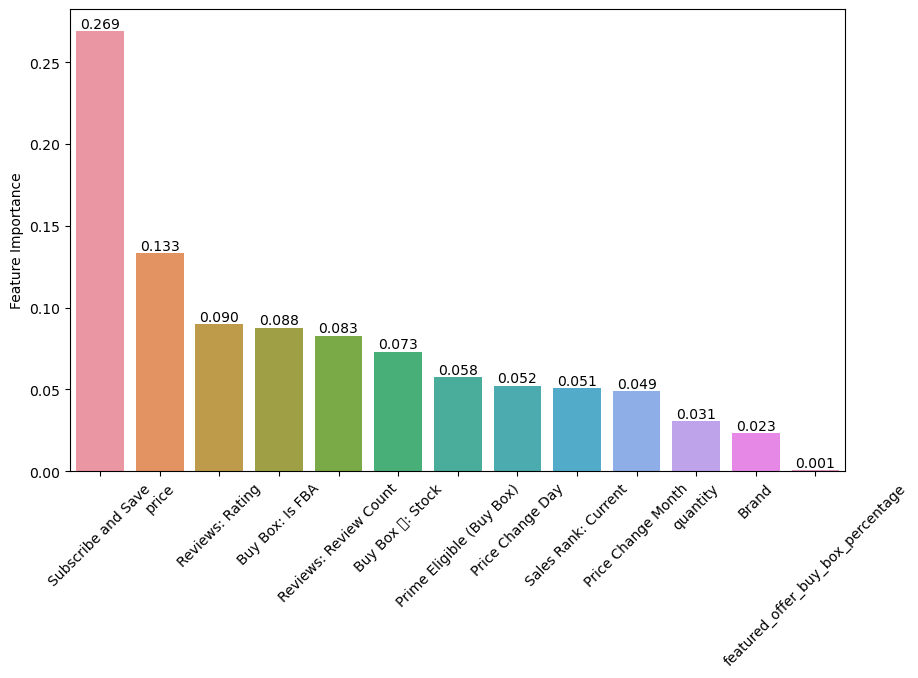

In [173]:
df_fi = pd.DataFrame(data = RF_pipe_smote["RF_model"].feature_importances_, index =X.columns,
                              columns = ["Feature Importance"])

df_fi = df_fi.sort_values("Feature Importance", ascending = False)

ax =sns.barplot(x = df_fi.index, y = 'Feature Importance', data = df_fi)
ax.bar_label(ax.containers[0],fmt="%.3f");
plt.xticks(rotation = 45)
plt.show();

In [174]:
y_pred = RF_pipe_smote.predict(X_test)
RF_f1_smote = f1_score(y_test, y_pred)
RF_accuracy_smote = accuracy_score(y_test, y_pred)

# XGBoost

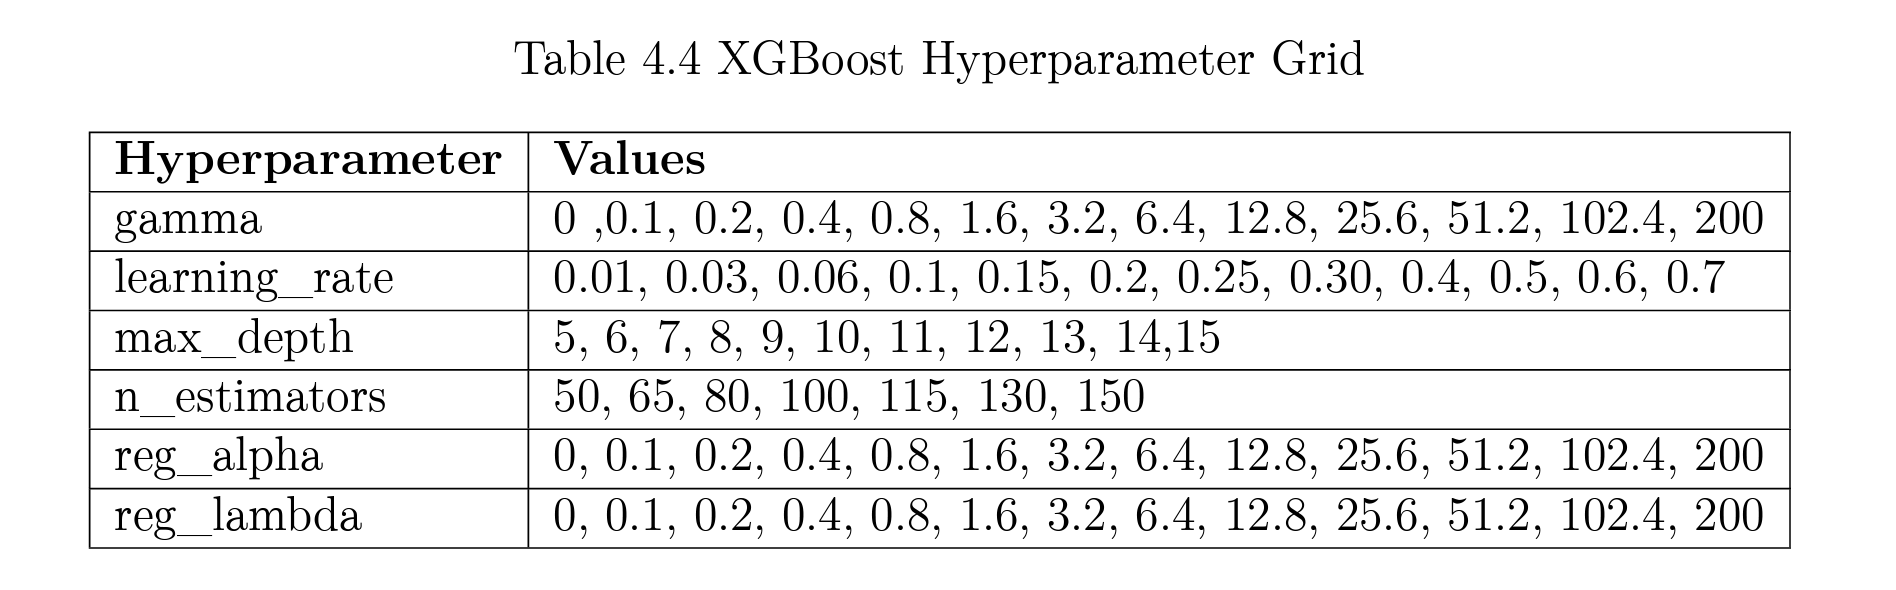

In [175]:
operations = [('column_trans',column_trans),('xgb_model', XGBClassifier(random_state=42))]
XGB_pipe = Pipeline(steps= operations)

XGB_pipe.fit(X_train, y_train)

Pipeline(steps=[('column_trans',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Buy Box: Is FBA',
                                                   'Prime Eligible (Buy Box)',
                                                   'Subscribe and Save']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Brand'])])),
                ('xgb_mod...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [176]:
eval_metric(XGB_pipe, X_train, y_train, X_test, y_test)

Test_Set
[[12  1]
 [ 5 24]]
              precision    recall  f1-score   support

           0       0.71      0.92      0.80        13
           1       0.96      0.83      0.89        29

    accuracy                           0.86        42
   macro avg       0.83      0.88      0.84        42
weighted avg       0.88      0.86      0.86        42


Train_Set
[[119   0]
 [  0 251]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00       251

    accuracy                           1.00       370
   macro avg       1.00      1.00      1.00       370
weighted avg       1.00      1.00      1.00       370



## CV

In [177]:
operations = [('column_trans',column_trans), ('xgb_model', XGBClassifier(random_state=42))]
xgb_pipe = Pipeline(steps= operations)

scores = cross_validate(xgb_pipe, X_train, y_train, scoring = ["accuracy", "precision", "recall", "f1"],
                        cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy     0.900
train_accuracy    1.000
test_precision    0.927
train_precision   1.000
test_recall       0.928
train_recall      1.000
test_f1           0.927
train_f1          1.000
dtype: float64

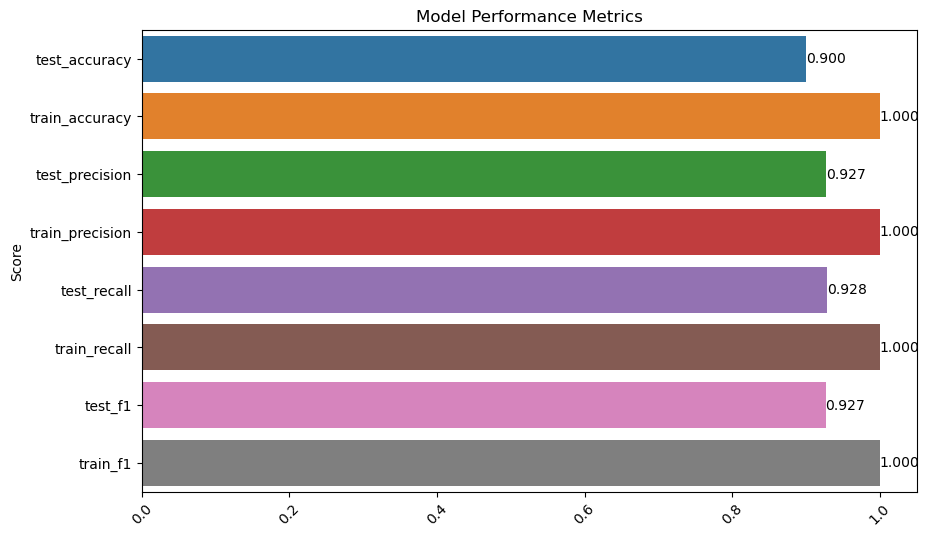

In [178]:
mean_scores = pd.DataFrame(scores).mean()[2:]

plt.figure(figsize=(10, 6))
ax = sns.barplot(y=mean_scores.index, x=mean_scores.values)
ax.bar_label(ax.containers[0], fmt='%.3f')
plt.xticks(rotation=45)
plt.ylabel('Score')
plt.title('Model Performance Metrics');

In [179]:
xgb_pipe.get_params()

{'memory': None,
 'steps': [('column_trans',
   ColumnTransformer(remainder=StandardScaler(),
                     transformers=[('onehotencoder',
                                    OneHotEncoder(drop='first',
                                                  handle_unknown='ignore',
                                                  sparse_output=False),
                                    ['Buy Box: Is FBA', 'Prime Eligible (Buy Box)',
                                     'Subscribe and Save']),
                                   ('ordinalencoder',
                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                   unknown_value=-1),
                                    ['Brand'])])),
  ('xgb_model',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, device=None, early_stopping_rounds=None,
          

## Grid Search

In [180]:
param_grid = {
    "xgb_model__n_estimators": [50, 100, 200],
    "xgb_model__max_depth": [3, 4, 5],
    "xgb_model__learning_rate": [0.01, 0.1, 1.0],
    "xgb_model__subsample": [0.5, 0.8],
    "xgb_model__colsample_bytree": [0.5, 0.8]}

In [181]:
operations = [('column_trans',column_trans), ('xgb_model', XGBClassifier(random_state=42))]
xgb_pipe = Pipeline(steps= operations)

xgb_grid = GridSearchCV(xgb_pipe, param_grid, scoring = "f1", n_jobs = -1)

xgb_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('column_trans',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Buy '
                                                                          'Box: '
                                                                          'Is '
                                                                          'FBA',
                                                                          'Prime '
                                                                          'Eligible '
                                                                          '(Buy '
                                                                          'Box)',
                                                                          'Subscribe '
                                                                          'and '
                                                                          'Save']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        un...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgb_model__colsample_bytree': [0.5, 0.8],
                         'xgb_model__learning_rate': [0.01, 0.1, 1.0],
                         'xgb_model__max_depth': [3, 4, 5],
                         'xgb_model__n_estimators': [50, 100, 200],
                         'xgb_model__subsample': [0.5, 0.8]},
             scoring='f1')

In [182]:
eval_metric(xgb_grid, X_train, y_train, X_test, y_test)

Test_Set
[[12  1]
 [ 5 24]]
              precision    recall  f1-score   support

           0       0.71      0.92      0.80        13
           1       0.96      0.83      0.89        29

    accuracy                           0.86        42
   macro avg       0.83      0.88      0.84        42
weighted avg       0.88      0.86      0.86        42


Train_Set
[[119   0]
 [  0 251]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00       251

    accuracy                           1.00       370
   macro avg       1.00      1.00      1.00       370
weighted avg       1.00      1.00      1.00       370



In [183]:
xgb_grid.best_params_

{'xgb_model__colsample_bytree': 0.5,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__max_depth': 5,
 'xgb_model__n_estimators': 200,
 'xgb_model__subsample': 0.8}

In [184]:
operations = [
    ('preprocessor', column_trans),
    ('xgb_model', XGBClassifier(random_state=42,
                                colsample_bytree =0.5,
                                learning_rate=0.1,
                                max_depth=5,
                                n_estimators=200,
                                subsample=0.8))]

xgb_pipe = Pipeline(steps= operations)

xgb_pipe .fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Buy Box: Is FBA',
                                                   'Prime Eligible (Buy Box)',
                                                   'Subscribe and Save']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Brand'])])),
                ('xgb_mod...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [185]:
y_pred = xgb_pipe.predict(X_test)
xgb_f1 = f1_score(y_test, y_pred)
xgb_accuracy = accuracy_score(y_test, y_pred)

## Smote

In [187]:
# Define the pipeline operations
operations = [
    ('preprocessor', column_trans),
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('xgb_model', XGBClassifier(random_state=42))
]

# Create the pipeline
xgb_pipe_smote = Pipeline(steps=operations)

# Fit the model
xgb_pipe_smote.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Buy Box: Is FBA',
                                                   'Prime Eligible (Buy Box)',
                                                   'Subscribe and Save']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Brand'])])),
                ('smote',...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [188]:
eval_metric(xgb_pipe_smote, X_train, y_train, X_test, y_test)

Test_Set
[[12  1]
 [ 5 24]]
              precision    recall  f1-score   support

           0       0.71      0.92      0.80        13
           1       0.96      0.83      0.89        29

    accuracy                           0.86        42
   macro avg       0.83      0.88      0.84        42
weighted avg       0.88      0.86      0.86        42


Train_Set
[[119   0]
 [  0 251]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00       251

    accuracy                           1.00       370
   macro avg       1.00      1.00      1.00       370
weighted avg       1.00      1.00      1.00       370



In [189]:
# Define the pipeline operations
operations = [
    ('preprocessor', column_trans),
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('xgb_model', XGBClassifier(random_state=42))]


xgb_pipe_smote = Pipeline(steps= operations)

scores = cross_validate(xgb_pipe_smote, X_train, y_train, scoring = ["accuracy", "precision", "recall", "f1"],
                        cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy     0.903
train_accuracy    1.000
test_precision    0.945
train_precision   1.000
test_recall       0.913
train_recall      1.000
test_f1           0.927
train_f1          1.000
dtype: float64

In [190]:
# Define the pipeline operations
operations = [
    ('preprocessor', column_trans),
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('xgb_model', XGBClassifier(random_state=42))]


xgb_pipe_smote = Pipeline(steps= operations)

xgb_grid = GridSearchCV(xgb_pipe_smote, param_grid, scoring = "f1", n_jobs = -1)

xgb_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Buy '
                                                                          'Box: '
                                                                          'Is '
                                                                          'FBA',
                                                                          'Prime '
                                                                          'Eligible '
                                                                          '(Buy '
                                                                          'Box)',
                                                                          'Subscribe '
                                                                          'and '
                                                                          'Save']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        un...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgb_model__colsample_bytree': [0.5, 0.8],
                         'xgb_model__learning_rate': [0.01, 0.1, 1.0],
                         'xgb_model__max_depth': [3, 4, 5],
                         'xgb_model__n_estimators': [50, 100, 200],
                         'xgb_model__subsample': [0.5, 0.8]},
             scoring='f1')

In [191]:
eval_metric(xgb_grid, X_train, y_train, X_test, y_test)

Test_Set
[[12  1]
 [ 4 25]]
              precision    recall  f1-score   support

           0       0.75      0.92      0.83        13
           1       0.96      0.86      0.91        29

    accuracy                           0.88        42
   macro avg       0.86      0.89      0.87        42
weighted avg       0.90      0.88      0.88        42


Train_Set
[[116   3]
 [  6 245]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       119
           1       0.99      0.98      0.98       251

    accuracy                           0.98       370
   macro avg       0.97      0.98      0.97       370
weighted avg       0.98      0.98      0.98       370



## Best Score

In [192]:
xgb_grid.best_score_

0.9445801244887482

In [193]:
xgb_grid.best_params_

{'xgb_model__colsample_bytree': 0.5,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__max_depth': 3,
 'xgb_model__n_estimators': 100,
 'xgb_model__subsample': 0.5}

## Feature Importancy

In [194]:
operations = [
    ('preprocessor', column_trans),
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('xgb_model', XGBClassifier(random_state=42,
                                colsample_bytree =0.5,
                                learning_rate=0.1,
                                max_depth=3,
                                n_estimators=100,
                                subsample=0.5))]

xgb_pipe_smote = Pipeline(steps= operations)

xgb_pipe_smote .fit(X_train, y_train)
xgb_pipe_smote['xgb_model'].feature_importances_

array([0.20860009, 0.11328804, 0.03480316, 0.04566452, 0.06440958,
       0.07627091, 0.06225661, 0.06602321, 0.03866386, 0.06236411,
       0.12479565, 0.05545984, 0.0474004 ], dtype=float32)

In [195]:
feats = pd.DataFrame(index=X.columns, data= xgb_pipe ['xgb_model'].feature_importances_, columns=['xgb_importance'])
xgb_imp_feats = feats.sort_values("xgb_importance", ascending = False)
xgb_imp_feats

xgb_importance
price                                       0.329
quantity                                    0.147
Subscribe and Save                          0.135
Reviews: Review Count                       0.060
Buy Box 🚚: Stock                            0.054
Reviews: Rating                             0.053
Sales Rank: Current                         0.043
Buy Box: Is FBA                             0.043
Prime Eligible (Buy Box)                    0.039
Price Change Month                          0.037
Brand                                       0.034
Price Change Day                            0.027
featured_offer_buy_box_percentage           0.000

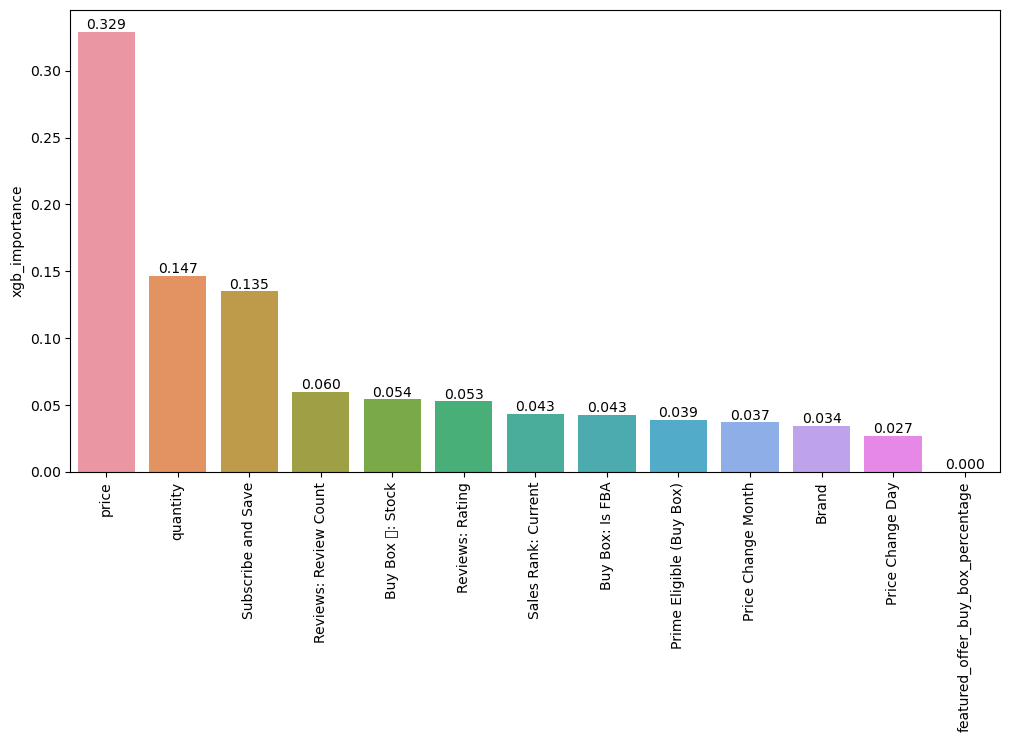

In [196]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=xgb_imp_feats, x=xgb_imp_feats.index, y='xgb_importance')
ax.bar_label(ax.containers[0], fmt="%.3f")
plt.xticks(rotation=90);

In [197]:
y_pred = xgb_pipe_smote.predict(X_test)
xgb_f1_smote = f1_score(y_test, y_pred)
xgb_accuracy_smote = accuracy_score(y_test, y_pred)

# ADABoost

In [198]:
operations = [('column_trans',column_trans),('ada_model', AdaBoostClassifier(random_state=42))]
ada_pipe = Pipeline(steps= operations)

ada_pipe.fit(X_train, y_train)

Pipeline(steps=[('column_trans',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Buy Box: Is FBA',
                                                   'Prime Eligible (Buy Box)',
                                                   'Subscribe and Save']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Brand'])])),
                ('ada_model', AdaBoostClassifier(random_state=42))])

In [199]:
eval_metric(ada_pipe, X_train, y_train, X_test, y_test)

Test_Set
[[10  3]
 [ 2 27]]
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.90      0.93      0.92        29

    accuracy                           0.88        42
   macro avg       0.87      0.85      0.86        42
weighted avg       0.88      0.88      0.88        42


Train_Set
[[113   6]
 [  3 248]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       119
           1       0.98      0.99      0.98       251

    accuracy                           0.98       370
   macro avg       0.98      0.97      0.97       370
weighted avg       0.98      0.98      0.98       370



## CV

In [200]:
operations = [('column_trans',column_trans), ('ada_model', AdaBoostClassifier(random_state=42))]
ada_pipe = Pipeline(steps= operations)

scores = cross_validate(ada_pipe, X_train, y_train, scoring = ["accuracy", "precision", "recall", "f1"],
                        cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy     0.868
train_accuracy    0.976
test_precision    0.893
train_precision   0.981
test_recall       0.920
train_recall      0.985
test_f1           0.905
train_f1          0.983
dtype: float64

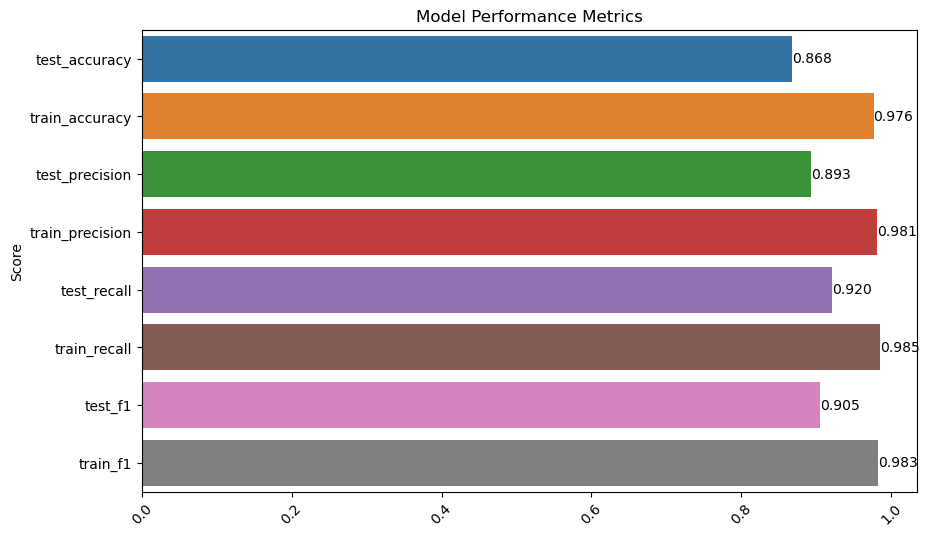

In [201]:
mean_scores = pd.DataFrame(scores).mean()[2:]

plt.figure(figsize=(10, 6))
ax = sns.barplot(y=mean_scores.index, x=mean_scores.values)
ax.bar_label(ax.containers[0], fmt='%.3f')
plt.xticks(rotation=45)
plt.ylabel('Score')
plt.title('Model Performance Metrics');

In [202]:
ada_pipe.get_params()

{'memory': None,
 'steps': [('column_trans',
   ColumnTransformer(remainder=StandardScaler(),
                     transformers=[('onehotencoder',
                                    OneHotEncoder(drop='first',
                                                  handle_unknown='ignore',
                                                  sparse_output=False),
                                    ['Buy Box: Is FBA', 'Prime Eligible (Buy Box)',
                                     'Subscribe and Save']),
                                   ('ordinalencoder',
                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                   unknown_value=-1),
                                    ['Brand'])])),
  ('ada_model', AdaBoostClassifier(random_state=42))],
 'verbose': False,
 'column_trans': ColumnTransformer(remainder=StandardScaler(),
                   transformers=[('onehotencoder',
                                  OneHotEncoder

## Grid Search

In [203]:
param_grid = {
    "ada_model__n_estimators": [50, 100, 200],
    "ada_model__learning_rate": [0.01, 0.1, 0.5, 1]
}

In [204]:
operations = [('column_trans',column_trans), ('ada_model', AdaBoostClassifier(random_state=42))]
ada_pipe = Pipeline(steps= operations)

ada_grid = GridSearchCV(ada_pipe, param_grid, scoring = "f1", n_jobs = -1)

ada_grid.fit(X_train, y_train)

/Users/enejanhayytjanova/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/enejanhayytjanova/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/enejanhayytjanova/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/enejanhayytjanova/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.

GridSearchCV(estimator=Pipeline(steps=[('column_trans',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Buy '
                                                                          'Box: '
                                                                          'Is '
                                                                          'FBA',
                                                                          'Prime '
                                                                          'Eligible '
                                                                          '(Buy '
                                                                          'Box)',
                                                                          'Subscribe '
                                                                          'and '
                                                                          'Save']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Brand'])])),
                                       ('ada_model',
                                        AdaBoostClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'ada_model__learning_rate': [0.01, 0.1, 0.5, 1],
                         'ada_model__n_estimators': [50, 100, 200]},
             scoring='f1')

In [205]:
eval_metric(ada_grid, X_train, y_train, X_test, y_test)

Test_Set
[[11  2]
 [ 4 25]]
              precision    recall  f1-score   support

           0       0.73      0.85      0.79        13
           1       0.93      0.86      0.89        29

    accuracy                           0.86        42
   macro avg       0.83      0.85      0.84        42
weighted avg       0.87      0.86      0.86        42


Train_Set
[[ 97  22]
 [ 10 241]]
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       119
           1       0.92      0.96      0.94       251

    accuracy                           0.91       370
   macro avg       0.91      0.89      0.90       370
weighted avg       0.91      0.91      0.91       370



In [206]:
ada_grid.best_params_

{'ada_model__learning_rate': 0.1, 'ada_model__n_estimators': 100}

In [207]:
ada_grid.best_score_

0.920731461786632

In [208]:
operations = [('column_trans',column_trans),
              ('ada_model', AdaBoostClassifier(random_state=42,
                                                n_estimators=100,
                                                learning_rate=0.1))]

ada_pipe = Pipeline(steps= operations)

ada_pipe.fit(X_train, y_train)

Pipeline(steps=[('column_trans',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Buy Box: Is FBA',
                                                   'Prime Eligible (Buy Box)',
                                                   'Subscribe and Save']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Brand'])])),
                ('ada_model',
                 AdaBoostClassifier(learning_rate=0.1, n_estimators=100,
                                    random_state=42))])

In [209]:
y_pred = ada_pipe.predict(X_test)
ada_f1 = f1_score(y_test, y_pred)
ada_accuracy = accuracy_score(y_test, y_pred)

## Smote

In [210]:
# Define the pipeline operations
operations = [
    ('preprocessor', column_trans),
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('ada_model', AdaBoostClassifier(random_state=42))
]

# Create the pipeline
ada_pipe_smote = Pipeline(steps=operations)

# Fit the model
ada_pipe_smote.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Buy Box: Is FBA',
                                                   'Prime Eligible (Buy Box)',
                                                   'Subscribe and Save']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Brand'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
                ('ada_model', AdaBoostClassifier(random_state=42))])

In [211]:
eval_metric(ada_pipe_smote, X_train, y_train, X_test, y_test)

Test_Set
[[11  2]
 [ 3 26]]
              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.93      0.90      0.91        29

    accuracy                           0.88        42
   macro avg       0.86      0.87      0.86        42
weighted avg       0.88      0.88      0.88        42


Train_Set
[[114   5]
 [  7 244]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       119
           1       0.98      0.97      0.98       251

    accuracy                           0.97       370
   macro avg       0.96      0.97      0.96       370
weighted avg       0.97      0.97      0.97       370



In [212]:

# Define the pipeline operations
operations = [
    ('preprocessor', column_trans),
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('ada_model', AdaBoostClassifier(random_state=42))
]

# Create the pipeline
ada_pipe_smote = Pipeline(steps=operations)

scores = cross_validate(ada_pipe_smote, X_train, y_train, scoring = ["accuracy", "precision", "recall", "f1"],
                        cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy     0.876
train_accuracy    0.970
test_precision    0.912
train_precision   0.983
test_recall       0.912
train_recall      0.973
test_f1           0.909
train_f1          0.978
dtype: float64

In [213]:

# Define the pipeline operations
operations = [
    ('preprocessor', column_trans),
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('ada_model', AdaBoostClassifier(random_state=42))
]

# Create the pipeline
ada_pipe_smote = Pipeline(steps=operations)

ada_grid = GridSearchCV(ada_pipe_smote, param_grid, scoring = "f1", n_jobs = -1)

ada_grid.fit(X_train, y_train)

/Users/enejanhayytjanova/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/enejanhayytjanova/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/enejanhayytjanova/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/enejanhayytjanova/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Buy '
                                                                          'Box: '
                                                                          'Is '
                                                                          'FBA',
                                                                          'Prime '
                                                                          'Eligible '
                                                                          '(Buy '
                                                                          'Box)',
                                                                          'Subscribe '
                                                                          'and '
                                                                          'Save']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Brand'])])),
                                       ('smote',
                                        SMOTE(random_state=42,
                                              sampling_strategy='minority')),
                                       ('ada_model',
                                        AdaBoostClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'ada_model__learning_rate': [0.01, 0.1, 0.5, 1],
                         'ada_model__n_estimators': [50, 100, 200]},
             scoring='f1')

In [214]:
eval_metric(ada_grid, X_train, y_train, X_test, y_test)

Test_Set
[[12  1]
 [ 3 26]]
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       0.96      0.90      0.93        29

    accuracy                           0.90        42
   macro avg       0.88      0.91      0.89        42
weighted avg       0.91      0.90      0.91        42


Train_Set
[[ 81  38]
 [ 10 241]]
              precision    recall  f1-score   support

           0       0.89      0.68      0.77       119
           1       0.86      0.96      0.91       251

    accuracy                           0.87       370
   macro avg       0.88      0.82      0.84       370
weighted avg       0.87      0.87      0.87       370



## Best Score

In [215]:
ada_grid.best_score_

0.9095613904959698

In [216]:
ada_grid.best_params_

{'ada_model__learning_rate': 0.01, 'ada_model__n_estimators': 50}

## Feature Importancy

In [217]:
operations = [('column_trans',column_trans),
              ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
              ('ada_model', AdaBoostClassifier(random_state=42,
                                                n_estimators=50,
                                                learning_rate=0.01))]

ada_pipe_smote = Pipeline(steps= operations)

ada_pipe_smote.fit(X_train, y_train)
ada_pipe_smote['ada_model'].feature_importances_

array([0.08, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.92,
       0.  , 0.  ])

In [218]:
feats = pd.DataFrame(index=X.columns, data= ada_pipe['ada_model'].feature_importances_, columns=['ada_importance'])
ada_imp_feats = feats.sort_values("ada_importance", ascending = False)
ada_imp_feats

ada_importance
Subscribe and Save                          0.210
Buy Box 🚚: Stock                            0.190
Reviews: Rating                             0.160
Buy Box: Is FBA                             0.130
Prime Eligible (Buy Box)                    0.090
Price Change Day                            0.070
quantity                                    0.050
Brand                                       0.030
Price Change Month                          0.030
price                                       0.020
featured_offer_buy_box_percentage           0.010
Sales Rank: Current                         0.010
Reviews: Review Count                       0.000

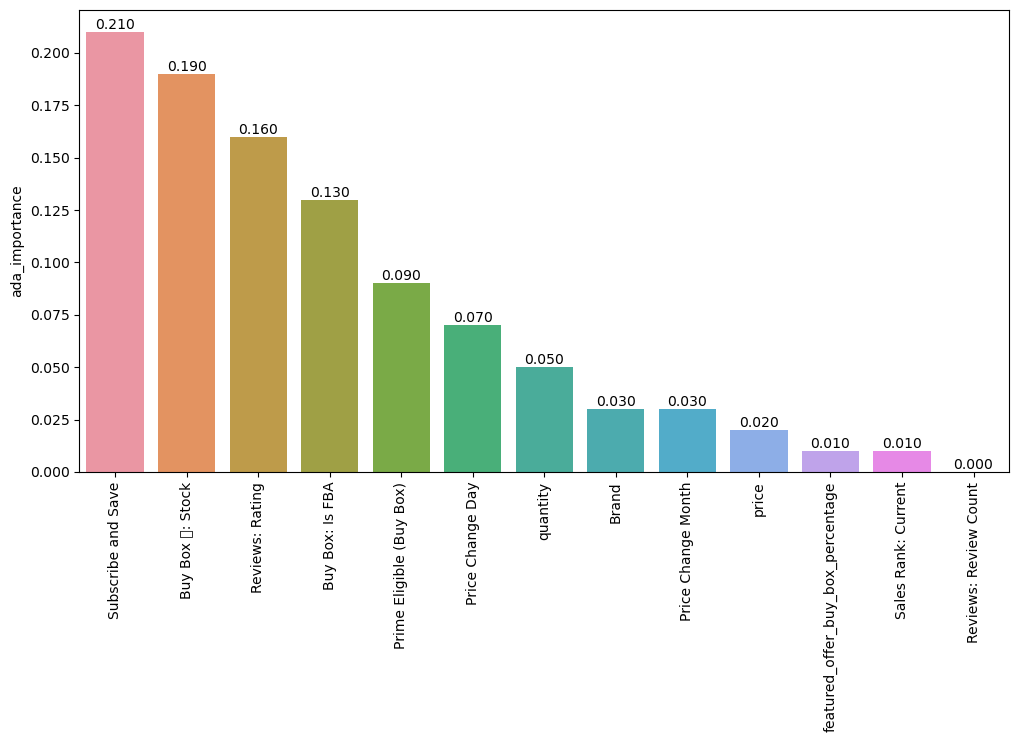

In [219]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=ada_imp_feats, x=ada_imp_feats.index, y='ada_importance')
ax.bar_label(ax.containers[0], fmt="%.3f")
plt.xticks(rotation=90);

In [220]:
y_pred = ada_pipe_smote.predict(X_test)
ada_f1_smote = f1_score(y_test, y_pred)
ada_accuracy_smote = accuracy_score(y_test, y_pred)

# Gradient Boosting

In [234]:
operations = [('column_trans',column_trans),('grad_model', GradientBoostingClassifier(random_state=42))]
grad_pipe = Pipeline(steps= operations)

grad_pipe.fit(X_train, y_train)

Pipeline(steps=[('column_trans',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Buy Box: Is FBA',
                                                   'Prime Eligible (Buy Box)',
                                                   'Subscribe and Save'])])),
                ('grad_model', GradientBoostingClassifier(random_state=42))])

In [235]:
eval_metric(grad_pipe, X_train, y_train, X_test, y_test)

Test_Set
[[13  0]
 [ 3 26]]
              precision    recall  f1-score   support

           0       0.81      1.00      0.90        13
           1       1.00      0.90      0.95        29

    accuracy                           0.93        42
   macro avg       0.91      0.95      0.92        42
weighted avg       0.94      0.93      0.93        42


Train_Set
[[119   0]
 [  1 250]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       119
           1       1.00      1.00      1.00       251

    accuracy                           1.00       370
   macro avg       1.00      1.00      1.00       370
weighted avg       1.00      1.00      1.00       370



## CV

In [236]:
operations = [('column_trans',column_trans), ('grad_model', GradientBoostingClassifier(random_state=42))]
grad_pipe = Pipeline(steps= operations)

scores = cross_validate(grad_pipe, X_train, y_train, scoring = ["accuracy", "precision", "recall", "f1"],
                        cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy     0.889
train_accuracy    0.995
test_precision    0.912
train_precision   0.998
test_recall       0.928
train_recall      0.996
test_f1           0.919
train_f1          0.997
dtype: float64

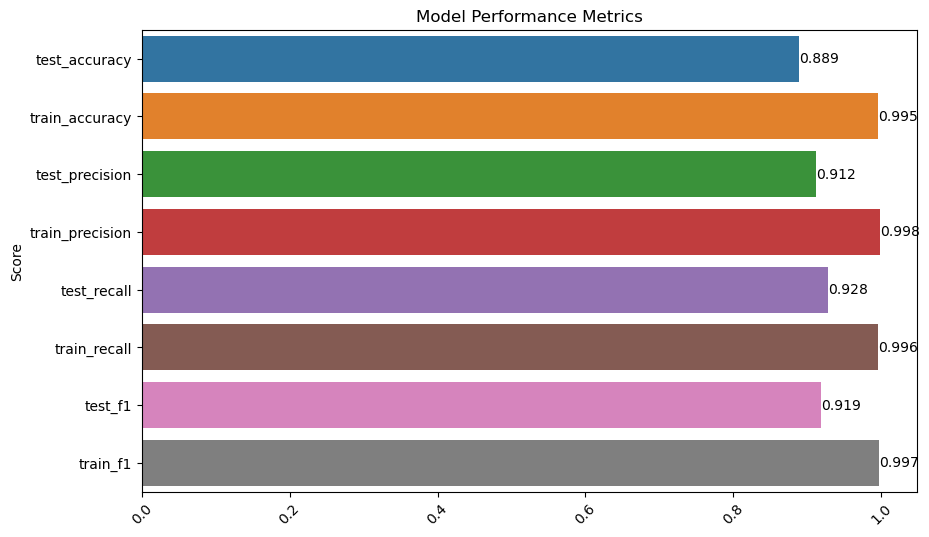

In [237]:
mean_scores = pd.DataFrame(scores).mean()[2:]

plt.figure(figsize=(10, 6))
ax = sns.barplot(y=mean_scores.index, x=mean_scores.values)
ax.bar_label(ax.containers[0], fmt='%.3f')
plt.xticks(rotation=45)
plt.ylabel('Score')
plt.title('Model Performance Metrics');

## Grid Search

In [238]:
param_grid = {
    "grad_model__n_estimators": [64, 100, 200],
    "grad_model__subsample": [0.5, 0.8],
    "grad_model__max_features": [None, 2, 3, 4],
    "grad_model__learning_rate": [0.1, 0.5, 1, 10],
    "grad_model__max_depth": [3, 4, 5]
}

In [239]:
operations = [('column_trans',column_trans), ('grad_model', GradientBoostingClassifier(random_state=101))]
grad_pipe = Pipeline(steps= operations)

grad_grid = GridSearchCV(grad_pipe, param_grid, scoring = "f1", n_jobs = -1)

grad_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('column_trans',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Buy '
                                                                          'Box: '
                                                                          'Is '
                                                                          'FBA',
                                                                          'Prime '
                                                                          'Eligible '
                                                                          '(Buy '
                                                                          'Box)',
                                                                          'Subscribe '
                                                                          'and '
                                                                          'Save'])])),
                                       ('grad_model',
                                        GradientBoostingClassifier(random_state=101))]),
             n_jobs=-1,
             param_grid={'grad_model__learning_rate': [0.1, 0.5, 1, 10],
                         'grad_model__max_depth': [3, 4, 5],
                         'grad_model__max_features': [None, 2, 3, 4],
                         'grad_model__n_estimators': [64, 100, 200],
                         'grad_model__subsample': [0.5, 0.8]},
             scoring='f1')

In [240]:
eval_metric(grad_grid, X_train, y_train, X_test, y_test)

Test_Set
[[11  2]
 [ 3 26]]
              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.93      0.90      0.91        29

    accuracy                           0.88        42
   macro avg       0.86      0.87      0.86        42
weighted avg       0.88      0.88      0.88        42


Train_Set
[[119   0]
 [  1 250]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       119
           1       1.00      1.00      1.00       251

    accuracy                           1.00       370
   macro avg       1.00      1.00      1.00       370
weighted avg       1.00      1.00      1.00       370



In [241]:
grad_grid.best_params_

{'grad_model__learning_rate': 0.1,
 'grad_model__max_depth': 5,
 'grad_model__max_features': 2,
 'grad_model__n_estimators': 64,
 'grad_model__subsample': 0.8}

In [242]:
operations = [('column_trans',column_trans), ('grad_model', GradientBoostingClassifier(learning_rate=0.1,
                                                                                       n_estimators=200,
                                                                                       max_depth=5,
                                                                                       subsample=0.8,
                                                                                       max_features=2,
                                                                                      random_state=42))]
grad_pipe = Pipeline(steps= operations)


grad_pipe.fit(X_train, y_train)

Pipeline(steps=[('column_trans',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Buy Box: Is FBA',
                                                   'Prime Eligible (Buy Box)',
                                                   'Subscribe and Save'])])),
                ('grad_model',
                 GradientBoostingClassifier(max_depth=5, max_features=2,
                                            n_estimators=200, random_state=42,
                                            subsample=0.8))])

In [243]:
y_pred = grad_pipe.predict(X_test)
grad_f1 = f1_score(y_test, y_pred)
grad_accuracy = accuracy_score(y_test, y_pred)

## Smote

In [231]:
# Define the pipeline operations
operations = [
    ('preprocessor', column_trans),
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('grad_model', GradientBoostingClassifier(random_state=42))
]

# Create the pipeline
grad_pipe_smote = Pipeline(steps=operations)

# Fit the model
grad_pipe_smote.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Buy Box: Is FBA',
                                                   'Prime Eligible (Buy Box)',
                                                   'Subscribe and Save']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Brand'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
                ('grad_model', GradientBoostingClassifier(random_state=42))])

In [232]:
eval_metric(grad_pipe_smote, X_train, y_train, X_test, y_test)

Test_Set
[[12  1]
 [ 4 25]]
              precision    recall  f1-score   support

           0       0.75      0.92      0.83        13
           1       0.96      0.86      0.91        29

    accuracy                           0.88        42
   macro avg       0.86      0.89      0.87        42
weighted avg       0.90      0.88      0.88        42


Train_Set
[[119   0]
 [  1 250]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       119
           1       1.00      1.00      1.00       251

    accuracy                           1.00       370
   macro avg       1.00      1.00      1.00       370
weighted avg       1.00      1.00      1.00       370



In [233]:
# Define the pipeline operations
operations = [
    ('preprocessor', column_trans),
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('grad_model', GradientBoostingClassifier(random_state=42))
]

# Create the pipeline
grad_pipe_smote = Pipeline(steps=operations)

grad_grid = GridSearchCV(grad_pipe, param_grid, scoring = "f1", n_jobs = -1)

grad_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('column_trans',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Buy '
                                                                          'Box: '
                                                                          'Is '
                                                                          'FBA',
                                                                          'Prime '
                                                                          'Eligible '
                                                                          '(Buy '
                                                                          'Box)',
                                                                          'Subscribe '
                                                                          'and '
                                                                          'Save']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        un...
                                                                         ['Brand'])])),
                                       ('grad_model',
                                        GradientBoostingClassifier(max_depth=5,
                                                                   max_features=2,
                                                                   n_estimators=200,
                                                                   random_state=42,
                                                                   subsample=0.8))]),
             n_jobs=-1,
             param_grid={'grad_model__learning_rate': [0.1, 0.5, 1, 10],
                         'grad_model__max_depth': [3, 4, 5],
                         'grad_model__max_features': [None, 2, 3, 4],
                         'grad_model__n_estimators': [64, 100, 200],
                         'grad_model__subsample': [0.5, 0.8]},
             scoring='f1')

In [234]:
eval_metric(grad_grid, X_train, y_train, X_test, y_test)

Test_Set
[[12  1]
 [ 3 26]]
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       0.96      0.90      0.93        29

    accuracy                           0.90        42
   macro avg       0.88      0.91      0.89        42
weighted avg       0.91      0.90      0.91        42


Train_Set
[[119   0]
 [  0 251]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00       251

    accuracy                           1.00       370
   macro avg       1.00      1.00      1.00       370
weighted avg       1.00      1.00      1.00       370



## Best Score

In [244]:
grad_grid.best_score_

0.9300168590421404

In [245]:
grad_grid.best_params_

{'grad_model__learning_rate': 0.1,
 'grad_model__max_depth': 5,
 'grad_model__max_features': 2,
 'grad_model__n_estimators': 64,
 'grad_model__subsample': 0.8}

## Feature Importancy

In [246]:
operations = [('column_trans',column_trans), ('grad_model', GradientBoostingClassifier(learning_rate=0.5,
                                                                                       n_estimators=200,
                                                                                       max_depth=5,
                                                                                       subsample=0.8,
                                                                                       max_features=4,
                                                                                      random_state=101))]
grad_pipe_smote = Pipeline(steps= operations)


grad_pipe_smote.fit(X_train, y_train)
grad_pipe_smote['grad_model'].feature_importances_

array([0.0965097 , 0.05186104, 0.01130837, 0.10078303, 0.09456792,
       0.10546196, 0.01670075, 0.05847532, 0.33737318, 0.04250095,
       0.08445778])

In [247]:
feats = pd.DataFrame(index=X.columns, data= grad_pipe['grad_model'].feature_importances_, columns=['grad_importance'])
grad_imp_feats = feats.sort_values("grad_importance", ascending = False)
grad_imp_feats

grad_importance
Subscribe and Save                  0.329
Reviews: Rating                     0.122
Buy Box 🚚: Stock                    0.113
price                               0.103
Prime Eligible (Buy Box)            0.087
Reviews: Review Count               0.081
Price Change Day                    0.053
Price Change Month                  0.038
Buy Box: Is FBA                     0.032
quantity                            0.032
Sales Rank: Current                 0.012

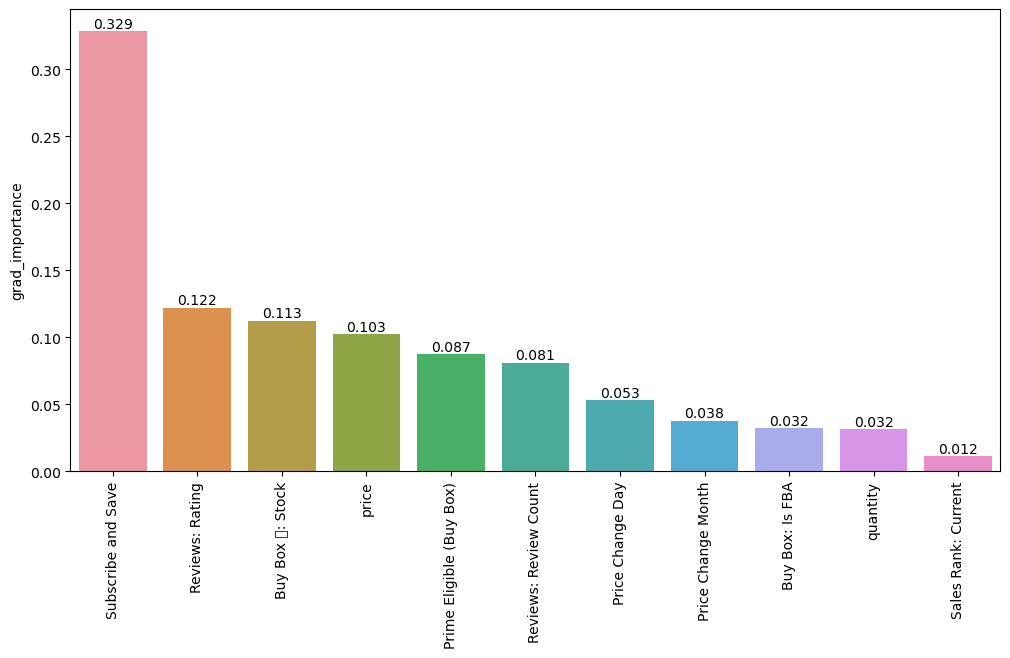

In [248]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=grad_imp_feats, x=grad_imp_feats.index, y='grad_importance')
ax.bar_label(ax.containers[0], fmt="%.3f")
plt.xticks(rotation=90);

In [249]:
y_pred = grad_pipe_smote.predict(X_test)
grad_f1_smote = f1_score(y_test, y_pred)
grad_accuracy_smote = accuracy_score(y_test, y_pred)

## Light GBM

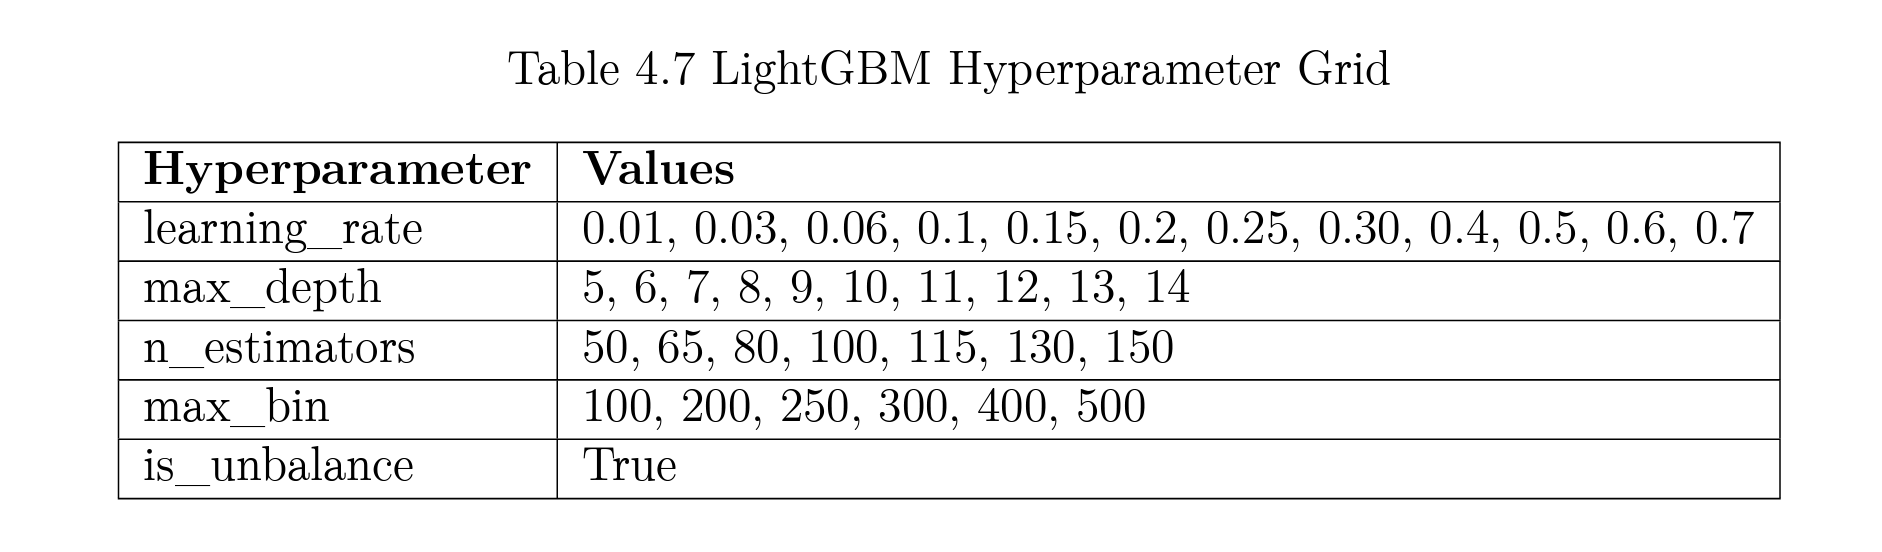

In [442]:
from lightgbm import LGBMClassifier

In [443]:
y_train.unique()

array([0, 1])

In [444]:
operations = [('column_trans',column_trans),('lgbm_model', LGBMClassifier(random_state=42))]
lgbm_pipe = Pipeline(steps= operations)

lgbm_pipe.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 104, number of negative: 380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 889
[LightGBM] [Info] Number of data points in the train set: 484, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214876 -> initscore=-1.295780
[LightGBM] [Info] Start training from score -1.295780
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Pipeline(steps=[('column_trans',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Prime Eligible (Buy Box)',
                                                   'Subscribe and Save']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Categories: Sub',
                                                   'Brand'])])),
                ('lgbm_model', LGBMClassifier(random_state=42))])

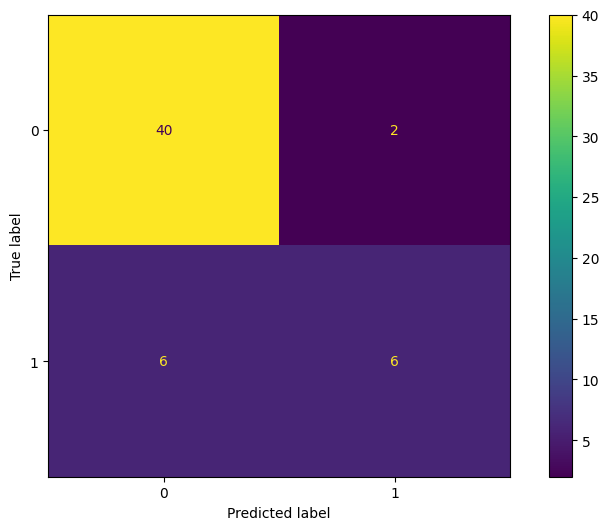

In [445]:
ConfusionMatrixDisplay.from_estimator(lgbm_pipe, X_test, y_test);

In [446]:
eval_metric(lgbm_pipe, X_train, y_train, X_test, y_test)

Test_Set
[[40  2]
 [ 6  6]]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        42
           1       0.75      0.50      0.60        12

    accuracy                           0.85        54
   macro avg       0.81      0.73      0.75        54
weighted avg       0.84      0.85      0.84        54


Train_Set
[[380   0]
 [  0 104]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       380
           1       1.00      1.00      1.00       104

    accuracy                           1.00       484
   macro avg       1.00      1.00      1.00       484
weighted avg       1.00      1.00      1.00       484



### Light GBM CV

In [447]:
operations = [('column_trans',column_trans), ('lgbm_model', LGBMClassifier(random_state=42))]
lgbm_pipe = Pipeline(steps= operations)

scores = cross_validate(lgbm_pipe, X_train, y_train, scoring = ["accuracy", "precision", "recall", "f1"],
                        cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

[LightGBM] [Info] Number of positive: 93, number of negative: 342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 435, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.213793 -> initscore=-1.302211
[LightGBM] [Info] Start training from score -1.302211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


test_accuracy     0.860
train_accuracy    1.000
test_precision    0.773
train_precision   1.000
test_recall       0.497
train_recall      1.000
test_f1           0.585
train_f1          1.000
dtype: float64

### Light GBM Grid Search

In [448]:
lgbm_pipe.get_params()

{'memory': None,
 'steps': [('column_trans',
   ColumnTransformer(remainder=StandardScaler(),
                     transformers=[('onehotencoder',
                                    OneHotEncoder(drop='first',
                                                  handle_unknown='ignore',
                                                  sparse_output=False),
                                    ['Prime Eligible (Buy Box)',
                                     'Subscribe and Save']),
                                   ('ordinalencoder',
                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                   unknown_value=-1),
                                    ['Categories: Sub', 'Brand'])])),
  ('lgbm_model', LGBMClassifier(random_state=42))],
 'verbose': False,
 'column_trans': ColumnTransformer(remainder=StandardScaler(),
                   transformers=[('onehotencoder',
                                  OneHotEncoder(dr

In [449]:
param_grid = {'lgbm_model__learning_rate': [0.1, 1],
              'lgbm_model__n_estimators': [50, 100, 200],
              'lgbm_model__num_leaves': [20, 30, 50],
              'lgbm_model__max_depth': [-1, 3, 4, 5],
              'lgbm_model__subsample': [0.8, 1.0],
              'lgbm_model__colsample_bytree': [0.8, 1.0]}

In [450]:
operations = [('column_trans',column_trans), ('lgbm_model', LGBMClassifier(random_state=42))]
lgbm_pipe = Pipeline(steps= operations)

lgbm_grid = GridSearchCV(lgbm_pipe, param_grid, scoring = "f1", n_jobs = -1)

lgbm_grid.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 104, number of negative: 380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 889
[LightGBM] [Info] Number of data points in the train set: 484, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214876 -> initscore=-1.295780
[LightGBM] [Info] Start training from score -1.295780
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

GridSearchCV(estimator=Pipeline(steps=[('column_trans',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Prime '
                                                                          'Eligible '
                                                                          '(Buy '
                                                                          'Box)',
                                                                          'Subscribe '
                                                                          'and '
                                                                          'Save']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Categories: '
                                                                          'Sub',
                                                                          'Brand'])])),
                                       ('lgbm_model',
                                        LGBMClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'lgbm_model__colsample_bytree': [0.8, 1.0],
                         'lgbm_model__learning_rate': [0.1, 1],
                         'lgbm_model__max_depth': [-1, 3, 4, 5],
                         'lgbm_model__n_estimators': [50, 100, 200],
                         'lgbm_model__num_leaves': [20, 30, 50],
                         'lgbm_model__subsample': [0.8, 1.0]},
             scoring='f1')

In [451]:
eval_metric(lgbm_grid, X_train, y_train, X_test, y_test)

Test_Set
[[38  4]
 [ 6  6]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        42
           1       0.60      0.50      0.55        12

    accuracy                           0.81        54
   macro avg       0.73      0.70      0.71        54
weighted avg       0.81      0.81      0.81        54


Train_Set
[[380   0]
 [  0 104]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       380
           1       1.00      1.00      1.00       104

    accuracy                           1.00       484
   macro avg       1.00      1.00      1.00       484
weighted avg       1.00      1.00      1.00       484



## Smote

In [452]:
# Define the pipeline operations
operations = [
    ('preprocessor', column_trans),
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('lgbm_model',  LGBMClassifier(random_state=42))
]

# Create the pipeline
lgbm_pipe_smote = Pipeline(steps=operations)

# Fit the model
lgbm_pipe_smote.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 380, number of negative: 380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2214
[LightGBM] [Info] Number of data points in the train set: 760, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Prime Eligible (Buy Box)',
                                                   'Subscribe and Save']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Categories: Sub',
                                                   'Brand'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
                ('lgbm_model', LGBMClassifier(random_state=42))])

In [453]:
eval_metric(lgbm_pipe_smote, X_train, y_train, X_test, y_test)

Test_Set
[[37  5]
 [ 6  6]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        42
           1       0.55      0.50      0.52        12

    accuracy                           0.80        54
   macro avg       0.70      0.69      0.70        54
weighted avg       0.79      0.80      0.79        54


Train_Set
[[380   0]
 [  0 104]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       380
           1       1.00      1.00      1.00       104

    accuracy                           1.00       484
   macro avg       1.00      1.00      1.00       484
weighted avg       1.00      1.00      1.00       484



In [454]:
lgbm_grid.best_params_

{'lgbm_model__colsample_bytree': 1.0,
 'lgbm_model__learning_rate': 1,
 'lgbm_model__max_depth': 5,
 'lgbm_model__n_estimators': 200,
 'lgbm_model__num_leaves': 20,
 'lgbm_model__subsample': 0.8}

### Light GBM Best Score

In [455]:
lgbm_grid.best_score_

0.6517962429727134

### Light GBM Feature Importancies

In [456]:
operations = [('column_trans',column_trans), ('lgbm_model', LGBMClassifier(random_state=42,
                                                                           colsample_bytree =1.0,
                                                                           learning_rate=1,
                                                                            max_depth=5,
                                                                            n_estimators=200,
                                                                            subsample=0.8,
                                                                            num_leaves=20))]
lgbm_pipe = Pipeline(steps= operations)

lgbm_pipe .fit(X_train, y_train)
lgbm_pipe['lgbm_model'].feature_importances_

[LightGBM] [Info] Number of positive: 104, number of negative: 380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 889
[LightGBM] [Info] Number of data points in the train set: 484, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214876 -> initscore=-1.295780
[LightGBM] [Info] Start training from score -1.295780
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

array([  4,   0,  90,  91,  93, 113,  36,  75, 120,  80,   7,  49,  20,
        35], dtype=int32)

In [457]:
feats = pd.DataFrame(index=X.columns, data= lgbm_pipe ['lgbm_model'].feature_importances_, columns=['lgbm_importance'])
lgbm_imp_feats = feats.sort_values("lgbm_importance", ascending = False)
lgbm_imp_feats

lgbm_importance
Brand                                 120
Buy Box 🚚: Stock                      113
Buy Box 🚚: Lowest                      93
Reviews: Review Count                  91
Reviews: Rating                        90
Prime Eligible (Buy Box)               80
Categories: Sub                        75
New Offer Count: Current               49
Buy Box: Is FBA                        36
Price Change Day                       35
Price Change Month                     20
Subscribe and Save                      7
Sales Rank: Current                     4
Sales Rank: Highest                     0

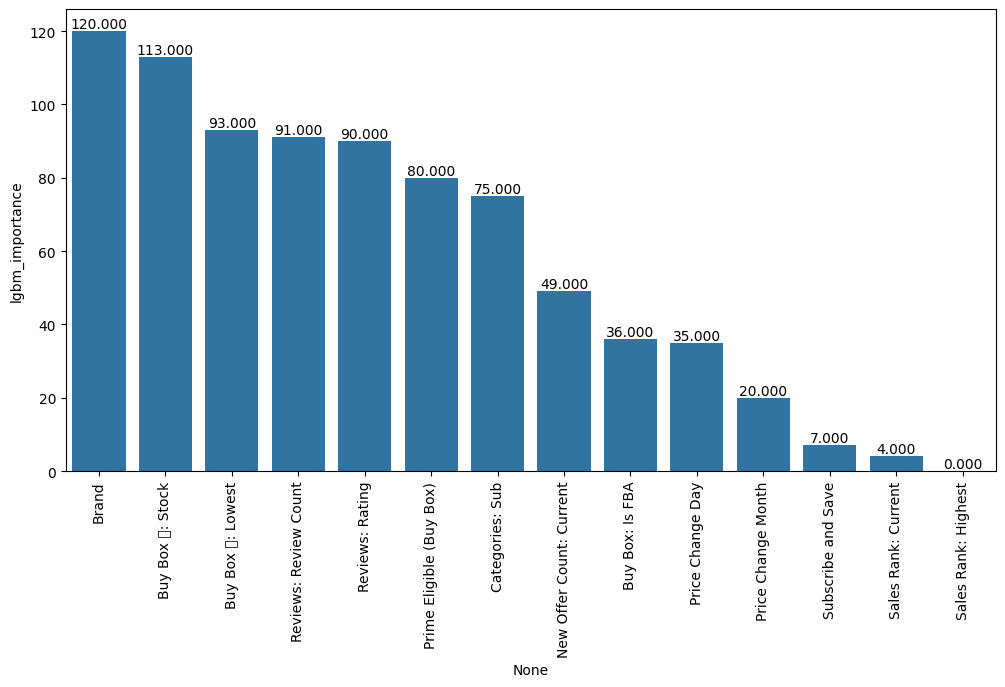

In [458]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=lgbm_imp_feats, x=lgbm_imp_feats.index, y='lgbm_importance')
ax.bar_label(ax.containers[0], fmt="%.3f")
plt.xticks(rotation=90);

In [459]:
y_pred = lgbm_pipe.predict(X_test)
lgbm_f1 = f1_score(y_test, y_pred)
lgbm_accuracy = accuracy_score(y_test, y_pred)

In [460]:
y_pred = lgbm_pipe_smote.predict(X_test)
lgbm_f1_smote = f1_score(y_test, y_pred)
lgbm_accuracy_smote = accuracy_score(y_test, y_pred)

## Comparing Models

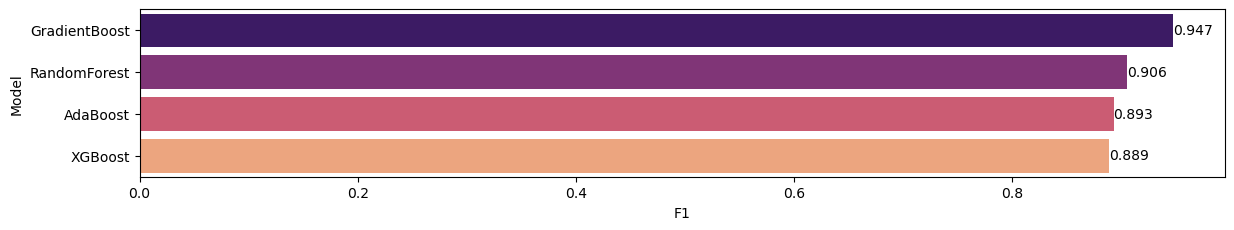

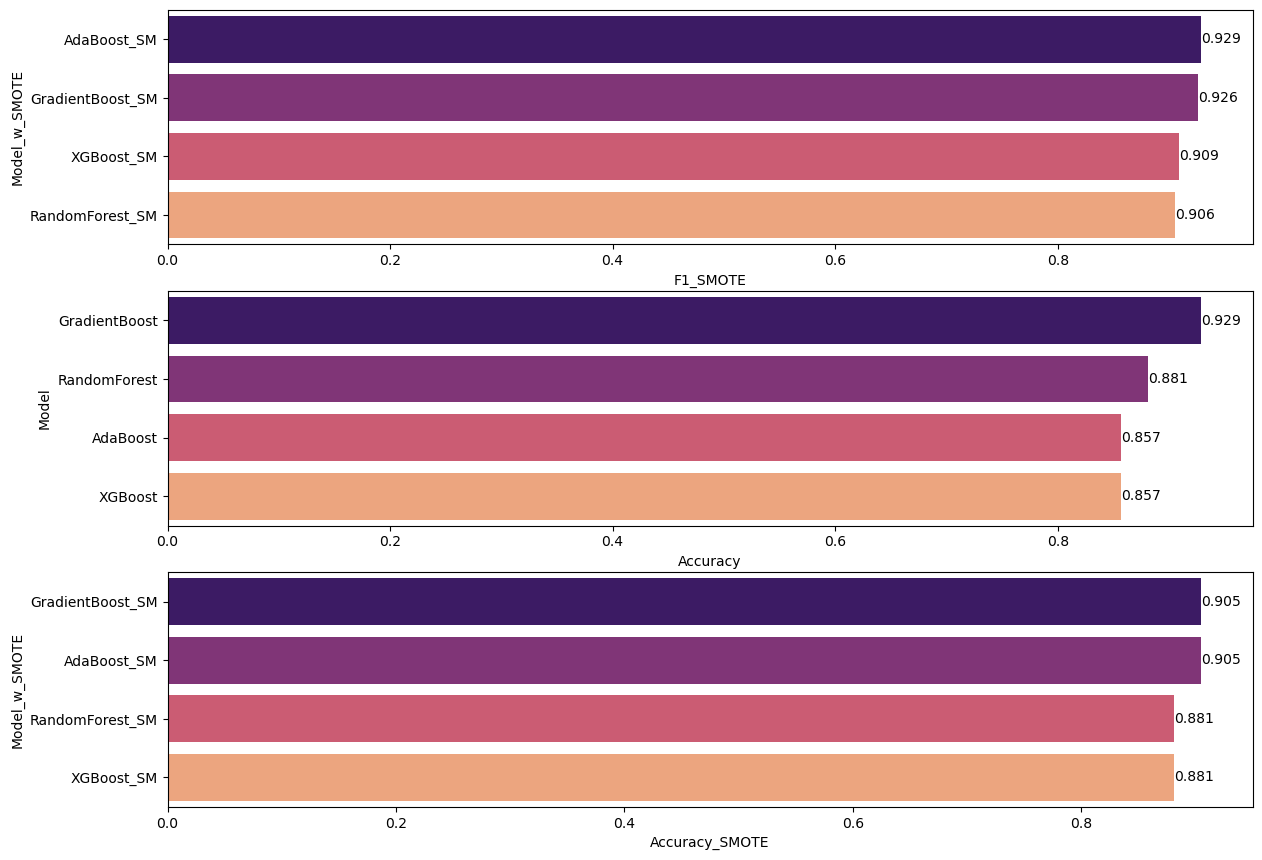

In [241]:
compare = pd.DataFrame({"Model": ["RandomForest", "AdaBoost", "GradientBoost", "XGBoost"],
                        "F1": [RF_f1, ada_f1, grad_f1, xgb_f1],
                        "Accuracy": [RF_accuracy, ada_accuracy, grad_accuracy, xgb_accuracy],
                        "Model_w_SMOTE":["RandomForest_SM", "AdaBoost_SM", "GradientBoost_SM", "XGBoost_SM"],
                        "F1_SMOTE": [RF_f1_smote, ada_f1_smote, grad_f1_smote, xgb_f1_smote],
                        "Accuracy_SMOTE": [RF_accuracy_smote, ada_accuracy_smote, grad_accuracy_smote, xgb_accuracy_smote]})


def labels(ax):
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.3f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment

plt.figure(figsize=(14,10))
plt.subplot(411)
compare = compare.sort_values(by="F1", ascending=False)
ax=sns.barplot(x="F1", y="Model", data=compare, palette="magma")
labels(ax)


plt.figure(figsize=(14,14))
plt.subplot(412)
compare = compare.sort_values(by="F1_SMOTE", ascending=False)
ax=sns.barplot(x="F1_SMOTE", y="Model_w_SMOTE", data=compare, palette="magma")
labels(ax)


plt.subplot(413)
compare = compare.sort_values(by="Accuracy", ascending=False)
ax=sns.barplot(x="Accuracy", y="Model", data=compare, palette="magma")
labels(ax)


plt.subplot(414)
compare = compare.sort_values(by="Accuracy_SMOTE", ascending=False)
ax=sns.barplot(x="Accuracy_SMOTE", y="Model_w_SMOTE", data=compare, palette="magma")
labels(ax)

plt.show()

In [242]:
compare

Model    F1  Accuracy     Model_w_SMOTE  F1_SMOTE  Accuracy_SMOTE
2  GradientBoost 0.947     0.929  GradientBoost_SM     0.926           0.905
1       AdaBoost 0.893     0.857       AdaBoost_SM     0.929           0.905
0   RandomForest 0.906     0.881   RandomForest_SM     0.906           0.881
3        XGBoost 0.889     0.857        XGBoost_SM     0.909           0.881

# ANN

In [281]:
from sklearn.preprocessing import OneHotEncoder

# Columns to one-hot encode
columns_to_encode = ['Buy Box: Is FBA', 'Prime Eligible (Buy Box)', 'Subscribe and Save', 'Brand']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform the data
encoded_data = encoder.fit_transform(df[columns_to_encode])

# Create a DataFrame with the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode))

# Drop the original columns and concatenate the new encoded columns
df = df.drop(columns=columns_to_encode).reset_index(drop=True)
df = pd.concat([df, encoded_df], axis=1)

# Display the resulting DataFrame
print(df)

# Save the updated DataFrame to a CSV file
df.to_csv('new_data_ANN.csv', index=False)

print("Data has been saved to 'new_data.csv'")


     price  quantity  featured_offer_buy_box_percentage  Sales Rank: Current  \
0   36.890        11                             84.750            40271.000   
1   25.830         0                             51.820            47872.000   
2   26.950        18                             89.620             9085.000   
3   21.490         0                              0.000            61977.000   
4   25.850         0                             29.410             4714.000   
5   34.850         0                              0.000            98376.000   
6   36.890        13                             17.860            38533.000   
7   33.490        19                             62.860           110079.000   
8   35.490        14                              0.000            13144.000   
9    8.950        14                             52.480            84827.000   
10  21.890        23                              0.000             2174.000   
11  14.950         0                    

In [282]:
import tensorflow as tf
from keras import models
from keras.layers import Dense,  Activation, Dropout
from keras.models import Sequential 
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report

from keras.layers import BatchNormalization

In [285]:
df = pd.read_csv("new_data_ANN.csv")

In [286]:
X = df.drop(["Buy Box Seller"], axis = 1)
y = df["Buy Box Seller"]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.10,
                                                    stratify=y,
                                                    random_state = 42)

In [290]:
y_train.shape

(370,)

In [293]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()

model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())  
model.add(Dropout(0.2))

model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())  
model.add(Dropout(0.3))

model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())  
model.add(Dropout(0.2))

model.add(Dense(32, activation="relu"))
model.add(BatchNormalization()) 

model.add(Dense(units=1, activation="sigmoid"))


opt = Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_accuracy",
                           mode="auto",
                           verbose=1,
                           patience=20)

history = model.fit(x=X_train, y=y_train, 
                    validation_data=(X_test, y_test),
                    batch_size=20, epochs=300,
                    callbacks=[early_stop])

Epoch 1/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5558 - loss: 0.7803 - val_accuracy: 0.3810 - val_loss: 1.6634
Epoch 2/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5446 - loss: 0.8319 - val_accuracy: 0.5238 - val_loss: 0.7795
Epoch 3/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6373 - loss: 0.7121 - val_accuracy: 0.6429 - val_loss: 0.6982
Epoch 4/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6143 - loss: 0.6778 - val_accuracy: 0.6429 - val_loss: 0.6768
Epoch 5/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6496 - loss: 0.6416 - val_accuracy: 0.6667 - val_loss: 0.6880
Epoch 6/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6699 - loss: 0.6493 - val_accuracy: 0.6429 - val_loss: 0.6735
Epoch 7/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6276 - loss: 0.6600 - val_accuracy: 0.6667 - val_loss: 0.6618
Epoch 8/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6679 - loss: 0.5970 - val_accuracy: 0.6667 - v

In [294]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred_probabilities = model.predict(X_train)
    y_train_pred = y_train_pred_probabilities.argmax(axis=1)
    y_pred_probabilities = model.predict(X_test)
    y_pred = y_pred_probabilities.argmax(axis=1)
    
    print("Test Set:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    print("\nTrain Set:")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [295]:
eval_metric(model, X_train, y_train, X_test, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
Test Set:
[[13  0]
 [29  0]]
              precision    recall  f1-score   support

           0       0.31      1.00      0.47        13
           1       0.00      0.00      0.00        29

    accuracy                           0.31        42
   macro avg       0.15      0.50      0.24        42
weighted avg       0.10      0.31      0.15        42


Train Set:
[[119   0]
 [251   0]]
              precision    recall  f1-score   support

           0       0.32      1.00      0.49       119
           1       0.00      0.00      0.00       251

    accuracy                           0.32       370
   macro avg       0.16      0.50      0.24       370
weighted avg       0.10      0.32      0.16       370



# Final Model - Gradient Boosting

In [250]:
df_.columns

Index(['price', 'quantity', 'Sales Rank: Current', 'Reviews: Rating',
       'Reviews: Review Count', 'Buy Box 🚚: Stock', 'Buy Box: Is FBA',
       'Prime Eligible (Buy Box)', 'Subscribe and Save', 'Buy Box Seller',
       'Price Change Month', 'Price Change Day'],
      dtype='object')

In [251]:
df_.shape

(412, 12)

In [267]:
df_.head()

price  quantity  Sales Rank: Current  Reviews: Rating  \
0 36.890        11            40271.000            4.700   
1 25.830         0            47872.000            4.400   
2 26.950        18             9085.000            4.600   
3 21.490         0            61977.000            4.400   
4 25.850         0             4714.000            4.700   

   Reviews: Review Count  Buy Box 🚚: Stock Buy Box: Is FBA  \
0                467.000            10.000              no   
1                 34.000            61.000              no   
2                512.000             6.000              no   
3                250.000             0.000              no   
4                581.000             0.000              no   

  Prime Eligible (Buy Box) Subscribe and Save  Buy Box Seller  \
0                       no                 no               1   
1                       no                 no               1   
2                       no                 no               1   
3                       no                 no               0   
4                       no                 no               0   

   Price Change Month  Price Change Day  
0                   1                 8  
1                   6                 3  
2                   5                25  
3                   6                 3  
4                   4                22

## Saving Final Model

In [252]:
X = df_.drop(["Buy Box Seller"], axis=1)
y = df_["Buy Box Seller"]

In [253]:
X.columns

Index(['price', 'quantity', 'Sales Rank: Current', 'Reviews: Rating',
       'Reviews: Review Count', 'Buy Box 🚚: Stock', 'Buy Box: Is FBA',
       'Prime Eligible (Buy Box)', 'Subscribe and Save', 'Price Change Month',
       'Price Change Day'],
      dtype='object')

In [260]:
import pickle
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Define column transformer
column_trans = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False), 
     ['Buy Box: Is FBA', 'Prime Eligible (Buy Box)', 'Subscribe and Save']),
    remainder=StandardScaler()
)

# Define operations for the pipeline
operations = [
    ('column_trans', column_trans), 
    ('grad_model', GradientBoostingClassifier(random_state=42))
]

# Create the pipeline
grad_pipe = Pipeline(steps=operations)

# Fit the pipeline
grad_pipe.fit(X, y)


Pipeline(steps=[('column_trans',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Buy Box: Is FBA',
                                                   'Prime Eligible (Buy Box)',
                                                   'Subscribe and Save'])])),
                ('grad_model', GradientBoostingClassifier(random_state=42))])

In [261]:

# Save the model to a file using pickle
with open('modell.pkl', 'wb') as file:
    pickle.dump(grad_pipe, file)

## Loading Model and Predict

In [259]:
import pickle
import pandas as pd

# Load the model from the file using pickle
with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Example new data in the same format as the training data
new_data = pd.read_csv("control.csv")

original = new_data['Buy Box Seller']


# Process the date column
new_data['Last Price Change'] = pd.to_datetime(new_data['Last Price Change'])
new_data['Price Change Month'] = new_data['Last Price Change'].dt.month
new_data['Price Change Day'] = new_data['Last Price Change'].dt.day



[1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
Number of correct predictions out of 30: 28
Accuracy: 93.33333333333333 %


In [264]:
# Ensure the new data is processed in the same way as the training data
new_data_transformed = loaded_model.named_steps['column_trans'].transform(new_data)

In [266]:
# Make predictions using the loaded model
predictions = loaded_model.named_steps['grad_model'].predict(new_data_transformed)
predictions


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0])

In [ ]:


# Create a DataFrame with the predictions and original values
result = pd.DataFrame(predictions, columns=['predictions'])
result['original'] = original

# Compare the predictions with the original values to see which ones are correct
result['Correct'] = result['predictions'] == result['original']

# Count how many predictions were correct
correct_count = result['Correct'].sum()

# Calculate the accuracy
accuracy = correct_count / len(result) * 100

# Print the result
print(f"Number of correct predictions out of {len(result)}:", correct_count)
print("Accuracy:", accuracy, "%")


# Streamlit

In [1]:
import streamlit as st
import base64
import pickle
import pandas as pd
from PIL import Image

# Function to set background image
def set_background(image_file):
    with open(image_file, "rb") as image:
        b64_encoded = base64.b64encode(image.read()).decode()
    css = f"""
    <style>
    .stApp {{
        background-image: url("data:image/jpeg;base64,{b64_encoded}");
        background-size: cover;
        background-position: center;
        background-repeat: no-repeat;
        background-attachment: fixed;
    }}
    </style>
    """
    st.markdown(css, unsafe_allow_html=True)

# Set the background image
set_background("1.png")

# Custom CSS for header background color only
st.markdown(
    """
    <style>
    .st-emotion-cache-12fmjuu {
        background-color: #ff9d3c;
    }
    
    .st-emotion-cache-1huvf7z,
    .st-emotion-cache-w3nhqi {
        background-color: transparent;
        color: inherit;
        border: none;
    }
    
    .st-emotion-cache-1wbqy5l span {
        color: inherit;
    }

    .st-emotion-cache-1pbsqtx {
        fill: inherit;
    }
    </style>
    """,
    unsafe_allow_html=True
)

# Adjust the heading with updated CSS
st.markdown("""
    <h1 style='text-align: center; color: #30373e; font-size: 55px; margin-top: -100px; margin-bottom: 0;'>Amazon Buy Box Prediction</h1>
    """, unsafe_allow_html=True)

# Load your images
img1 = Image.open("emsbay.jpg")
img2 = Image.open("whole-basket.png")

# Display the first image at the top of the sidebar
st.sidebar.image(img1, use_column_width=True)

# Load the trained model
@st.cache_resource
def load_model():
    with open('modell.pkl', 'rb') as file:
        return pickle.load(file)

model = load_model()

# Custom CSS for sidebar styling
st.markdown(
    """
    <style>
    /* Sidebar container styling */
    .stSidebar {
        background-color: #2f3841;
        color: white;
    }
    
    /* Styling for sidebar text and labels */
    .stSidebar .st-cqfsce,
    .stSidebar .st-emotion-cache-1gwvy71,
    .stSidebar .st-emotion-cache-6qob1r,
    .stSidebar .st-emotion-cache-1mi2ry5 {
        color: white;
    }

    /* Styling for sidebar input fields */
    .stSidebar input,
    .stSidebar select,
    .stSidebar .st-emotion-cache-1ny7cjd {
        color: white;
        background-color: #2f3841;
        border: 1px solid white;
    }

    .stSidebar .st-emotion-cache-1ny7cjd:hover {
        background-color: grey;
        border-color: grey;
    }

    /* Ensure sidebar labels are visible and white */
    .stSidebar label {
        color: white !important;
    }

    .stSidebar .st-emotion-cache-1mi2ry5 {
        font-size: 16px;
    }
    </style>
    """,
    unsafe_allow_html=True
)

# Custom CSS to style the sidebar header
st.markdown(
    """
    <style>
    /* Target the sidebar header */
    .st-emotion-cache-uzeiqp h2 {
        color: #30373e; /* Update the color to #30373e */
        font-size: 20px;
    }
    </style>
    """,
    unsafe_allow_html=True
)

st.sidebar.header("Enter Feature Values")

# Create input fields for each feature with proper labels
price = st.sidebar.number_input("Price", min_value=0.0, value=19.99, step=0.01)
quantity = st.sidebar.number_input("Quantity", min_value=1, value=1)
sales_rank_current = st.sidebar.number_input("Sales Rank: Current", min_value=0, value=500)
reviews_rating = st.sidebar.slider("Reviews: Rating", min_value=0.0, max_value=5.0, value=4.5, step=0.1)
reviews_review_count = st.sidebar.number_input("Reviews: Review Count", min_value=0, value=100)
buy_box_stock = st.sidebar.number_input("Buy Box 🚚: Stock", min_value=0, value=10)
buy_box_is_fba = st.sidebar.selectbox("Buy Box: Is FBA", options=["Yes", "No"], index=0)
prime_eligible = st.sidebar.selectbox("Prime Eligible (Buy Box)", options=["Yes", "No"], index=0)
subscribe_save = st.sidebar.selectbox("Subscribe and Save", options=["Yes", "No"], index=0)
price_change_month = st.sidebar.number_input("Price Change Month", min_value=1, max_value=12, value=6)
price_change_day = st.sidebar.number_input("Price Change Day", min_value=1, max_value=31, value=15)

# Add some space between the content (optional)
st.sidebar.markdown("<br>", unsafe_allow_html=True)

# Display the second image below the feature inputs
st.sidebar.image(img2, use_column_width=True)

# Process the input data and make predictions
if st.sidebar.button("Predict"):
    # Create a DataFrame with the input features
    input_data = pd.DataFrame({
        'price': [price],
        'quantity': [quantity],
        'Sales Rank: Current': [sales_rank_current],
        'Reviews: Rating': [reviews_rating],
        'Reviews: Review Count': [reviews_review_count],
        'Buy Box 🚚: Stock': [buy_box_stock],
        'Buy Box: Is FBA': [buy_box_is_fba],
        'Prime Eligible (Buy Box)': [prime_eligible],
        'Subscribe and Save': [subscribe_save],
        'Price Change Month': [price_change_month],
        'Price Change Day': [price_change_day]
    })

    # Check and update the ColumnTransformer
    input_data_transformed = model.named_steps['column_trans'].transform(input_data)

    # Make predictions
    prediction = model.named_steps['grad_model'].predict(input_data_transformed)
    
    # Convert prediction to meaningful label
    if prediction[0] == 1:
        prediction_result = "Buy-Box"
    else:
        prediction_result = "Not Buy-Box"
    
    # Display prediction result
    st.subheader("Prediction Results:")
    st.write(f"This Product Has **{prediction_result}**")


2024-08-09 21:44:29.099 
  command:

    streamlit run /Users/enejanhayytjanova/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-08-09 21:44:29.833 Session state does not function when running a script without `streamlit run`


In [3]:
streamlit run

SyntaxError: invalid syntax (1135476472.py, line 1)